## Generazione istanze

61.09828148156051

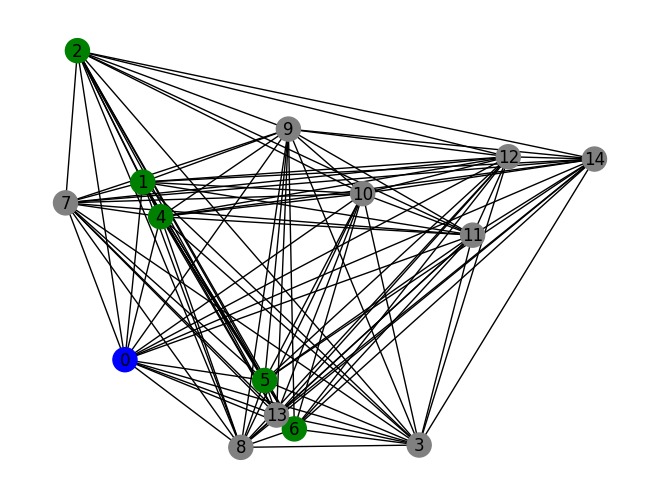

In [2]:
import networkx as nx 
import utility_function as uf

#generate a random graph
G=uf.random_euclidean_graph(15, 200)

#draw the graph with the type of node
uf.draw_graph(G)

#export in GML file
nx.write_gml(G, "istances/graph2.gml")
G[1][2]['weight']

## Euristica greedy e ad-hoc

Euristica Greedy per il problema GTSP. Alcune non sono greedy ma di ispirazione greedy.

### Nearest Neighbour (variante con autonomia)

A partire dal deposito di sceglie di spostarsi verso il cliente più vicino. Prima di farlo però si controlla che una volta raggiunto il nodo successivo sia possibile raggiungere la colonnina più vicina (altrimenti si resterebbe bloccati). Se non è possibile raggiungere la colonnina più vicina si sceglie la seconda più vicina e così via.

In alcuni potrebbe non riuscire a trovare una soluzione ammissibile e bloccarsi ritornando None.

Per evitare loop fra colonnine si tiene traccia di quelle già visitate e se si ritorna in una già vista si blocca l'algortimo ritornando None. Ogni volta che si visita un cliente si resetta la lista delle colonnine visitate.

È una variante dell'algoritmo Nearest Neighbour per il TSP.

In [1]:
import networkx as nx 
import utility_function as uf

def greedy_nearest_neighbour(G : nx.Graph, batteria_max : int):
    
    clienti = [node for node in G.nodes if G.nodes[node]['type'] == "cliente"]
    collonnine = [node for node in G.nodes if G.nodes[node]['type'] == "colonnina"]

    #inizializzazione
    nodo_attuale = 0
    batteria = batteria_max
    nodi_visitati = []
    nodi_da_visitare = clienti.copy() #devo anche tornare al deposito quindi lo devo visitare una seconda volta
    soluzione = [0]
    collonnine_visitate = [] #per evitare cicli
    batteria_per_nodo = [batteria_max] #per ogni nodo della soluzione salvo la batteria rimanente ()

    soluzione_trovata = True

    for _ in range(2): #sserve imporre che l'ultimo nodo sia il deposito (quando ho visitato tutti i nodi aggiungo il deposito ai nodi da visitare)
        while len(nodi_da_visitare) > 0:
            #print(nodi_da_visitare)
            #get the nearest node (cliente)
            nodo_prossimo = uf.get_nearest_node(G, nodo_attuale, nodi_da_visitare)

            #check if the battery is enough to go to the nearest node and to reach the nearest charging station
            if batteria - nodo_prossimo[0] - uf.get_nearest_node(G, nodo_prossimo[1], collonnine)[0] < 0:
            
                #print("batteria insufficiente")

                #go to the nearest charging station
                nodo_prossimo = uf.get_nearest_node(G, nodo_attuale, collonnine) #la colonnina più vicina
                
                #se vero allora sono in loop e non posso raggiungere nessun cliente
                if(int(nodo_prossimo[1]) in collonnine_visitate):
                    #print("sono in una colonnina ma non ho abbastanza batteria per raggiungere un cliente")
                    soluzione_trovata = False
                    break

                collonnine_visitate.append(nodo_prossimo[1])

                #aggiornamento dello stato
                batteria = batteria_max
                nodi_visitati.append(nodo_attuale)
                nodo_attuale = nodo_prossimo[1]
                soluzione.append(nodo_attuale)
                batteria_per_nodo.append(batteria)
            else:
                #aggiornamento dello stato
                batteria -= nodo_prossimo[0]
                nodi_visitati.append(nodo_attuale)
                nodo_attuale = nodo_prossimo[1]
                nodi_da_visitare.remove(nodo_attuale)
                soluzione.append(nodo_attuale)
                batteria_per_nodo.append(batteria)

                collonnine_visitate=[]
            
            #print("nodo attuale: ", nodo_attuale, "batteria: ", batteria, "nodi da visitare: ", nodi_da_visitare, "soluzione: ", soluzione)
        
        #print("torno al deposito")
        nodi_da_visitare=[0]

    if soluzione_trovata != False:
        #soluzione.append(0)
        #print("soluzione: ", soluzione)
        return soluzione, batteria_per_nodo
    else:
        return None
    

soluzione trovata:
[0, 4, 10, 13, 3, 14, 11, 5, 12, 7, 12, 6, 2, 12, 3, 1, 3, 8, 9, 3, 0]
batteria_per_nodo:
[150, 144.34314575050763, 107.28913112320981, 65.42028829229318, 150, 111.7900536509144, 84.13142027903574, 57.11290810682314, 150, 88.77908853994413, 150, 65.27692168009946, 150, 150, 150, 82.93286945157114, 150, 72.79896373752487, 150, 150, 78.83118660536766]
costo:  1530


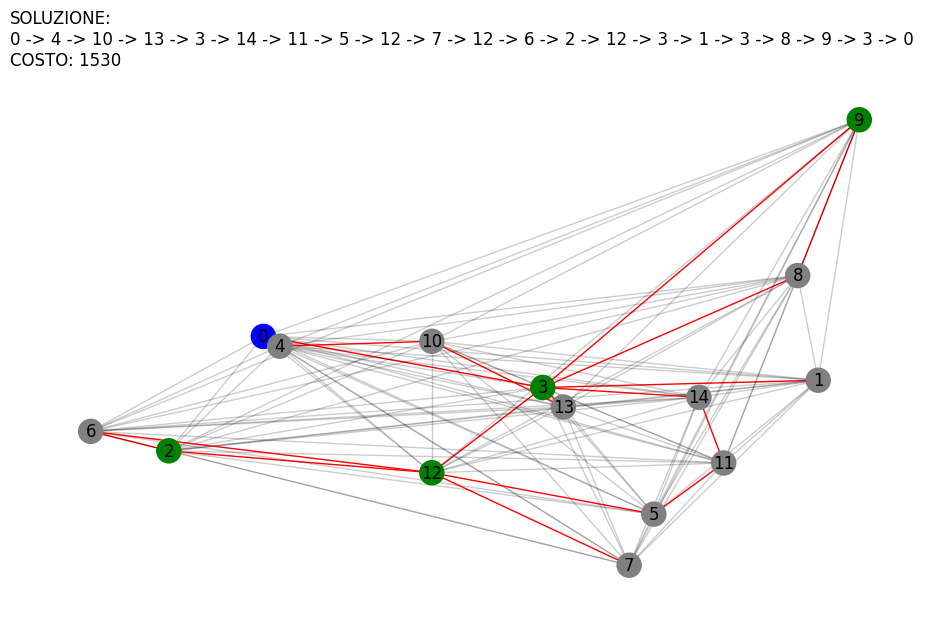

In [164]:
#RICHIEDE L'ESECUZIONE DELLA CELLA PRECEDENTE
import networkx as nx 
import utility_function as uf

#Caricamento del grafo da file
#scelta istanza
graph_file = "istances/graph.gml"
batteria_max = 150

#lettura grafo
G = nx.read_gml(graph_file, destringizer=int)

#applicazione algoritmo
soluzione, batteria_per_nodo = greedy_nearest_neighbour(G,batteria_max)

#controllo se la soluzione siste
if soluzione == None:
    print("soluzione non trovata. Batteria insufficiente per raggiungere tutti i clienti")
else:
    print("soluzione trovata:")
    print(soluzione)
    
    print("batteria_per_nodo:")
    print(batteria_per_nodo)

    costo = uf.costo(G, soluzione, batteria_per_nodo)
    print("costo: ", costo)

    #plot the solution
    uf.draw_solution(G, soluzione , costo)




### Random insertion

In [2]:
import networkx as nx 
import utility_function as uf
import random

def greedy_random_insertion(G : nx.Graph, batteria_max : int):
    
    clienti = [node for node in G.nodes if G.nodes[node]['type'] == "cliente"]
    collonnine = [node for node in G.nodes if G.nodes[node]['type'] == "colonnina"]

    #inizializzazione
    nodo_attuale = 0
    batteria = batteria_max
    nodi_visitati = []
    nodi_da_visitare = clienti.copy() #devo anche tornare al deposito quindi lo devo visitare una seconda volta
    batteria_per_nodo = [batteria_max] #per ogni nodo della soluzione salvo la batteria rimanente ()
    # inizio il tour dal deposito 
    tour = [nodo_attuale]
    #controllo se ci posso arrivare
    while len(nodi_da_visitare) > 0:

        
        random_node = get_random_node(G, nodi_da_visitare)

        #inserisco il nodo nella soluzione
        tour.append(random_node)
        nodi_da_visitare.remove(random_node)
        
    tour.append(0)
    batteria_per_nodo = uf.calcolo_batteria_per_nodo(G,tour,batteria_max)
        
    return tour, batteria_per_nodo

def get_random_node(G : nx.Graph, nodi_da_visitare : list):
        return random.choice(nodi_da_visitare)

### Random insertion con colonnine

In [3]:
import networkx as nx 
import utility_function as uf
import random

def greedy_random_insertion_colonnine(G : nx.Graph, batteria_max : int):

    ammissibile = False
    
    clienti = [node for node in G.nodes if G.nodes[node]['type'] == "cliente"]
    collonnine = [node for node in G.nodes if G.nodes[node]['type'] == "colonnina"]

    #inizializzazione
    while ammissibile == False:
        colonnine_da_visitare = collonnine.copy()
        nodi_da_visitare = clienti.copy()  #devo anche tornare al deposito quindi lo devo visitare una seconda volta
        batteria_per_nodo = [batteria_max] #per ogni nodo della soluzione salvo la batteria rimanente ()
        # inizio il tour dal deposito 
        tour = [0]

        while len(nodi_da_visitare) > 0:
            
            random_node = random.choice(nodi_da_visitare + colonnine_da_visitare)
          

            #inserisco il nodo nella soluzione
            tour.append(random_node)
            try :
                nodi_da_visitare.remove(random_node)
            except ValueError:
               colonnine_da_visitare.remove(random_node)
            
            #print(tour)
            
        tour.append(0)
        batteria_per_nodo = uf.calcolo_batteria_per_nodo(G,tour,batteria_max)

        ammissibile = not uf.check_batteria_negativa(batteria_per_nodo)
        #print(soluzione)
    return tour, batteria_per_nodo

In [167]:
import networkx as nx
import random
graph_file = "istances/graph.gml"
batteria_max = 250

#lettura grafo
G = nx.read_gml(graph_file, destringizer=int)

clienti = [node for node in G.nodes if G.nodes[node]['type'] == "cliente"]
collonnine = [node for node in G.nodes if G.nodes[node]['type'] == "colonnina"]
random_node = random.choice(clienti +collonnine)

print(random_node)

for i in range(0, len(clienti)):
    print(random.choice(clienti +collonnine))

3
13
12
12
7
3
9
5
13
2
8


soluzione trovata:
[0, 5, 3, 14, 6, 2, 4, 11, 3, 8, 7, 3, 13, 3, 10, 3, 1, 0]
batteria_per_nodo:
[250, 130.19181997876774, 250, 211.7900536509144, 63.12936617772934, 250, 199.22599090085558, 81.03969727930232, 250, 172.79896373752487, 46.93395668631942, 250, 240.5660188679434, 250, 216.98485196156165, 250, 182.93286945157115, 46.73815589777715]
costo:  1897


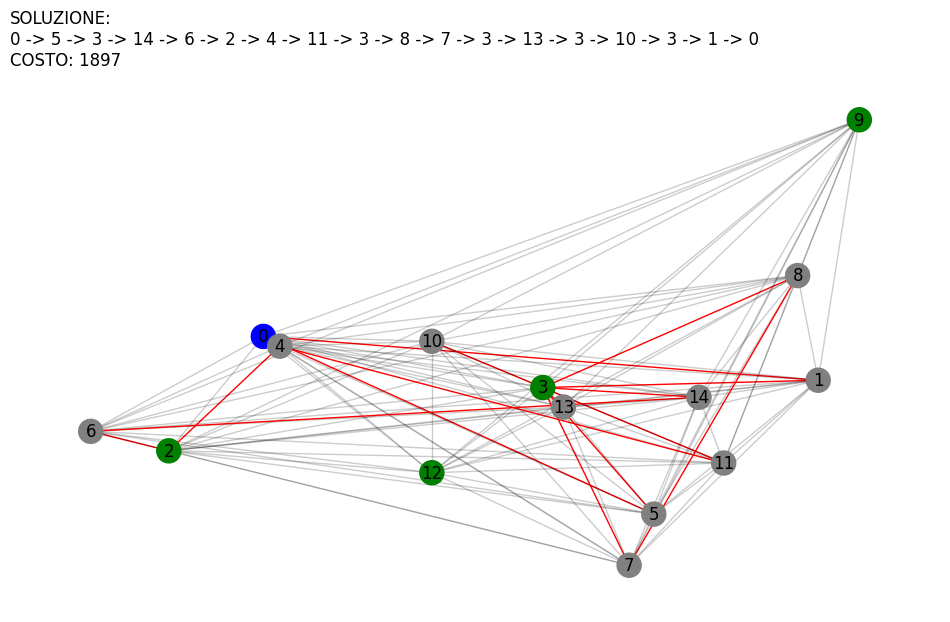

In [4]:
#RICHIEDE L'ESECUZIONE DELLA CELLA PRECEDENTE
import networkx as nx 
import utility_function as uf

#Caricamento del grafo da file
#scelta istanza

graph_file = "istances/graph.gml"
batteria_max = 250

#lettura grafo
G = nx.read_gml(graph_file, destringizer=int)

#applicazione algoritmo
soluzione, batteria_per_nodo = greedy_random_insertion(G,batteria_max)

#aggiungiamo le colonnine necessarie
soluzione, batteria_per_nodo = uf.add_colonnine_to_tour(G, soluzione, batteria_per_nodo, batteria_max)


#controllo se la soluzione siste
if soluzione == None:
    print("soluzione non trovata. Batteria insufficiente per raggiungere tutti i clienti")
else:
    print("soluzione trovata:")
    print(soluzione)
    
    print("batteria_per_nodo:")
    print(batteria_per_nodo)

    costo = uf.costo(G,soluzione, batteria_per_nodo)
   
    #costo = uf.costo(G, soluzione, batteria_per_nodo)
    print("costo: ", costo)

    #plot the solution
    uf.draw_solution(G, soluzione , costo)

soluzione trovata:
[0, 10, 8, 3, 11, 5, 1, 12, 13, 14, 7, 2, 6, 4, 0]
batteria_per_nodo:
[150, 108.95124849645242, 15.94587230776105, 150, 96.17621343680844, 69.15770126459584, 1.150348720918629, 150, 108.13115716908337, 74.88961689189404, 3.8262648741345657, 150, 129.3844718719117, 71.583087805438, 65.92623355594561]
costo:  1242


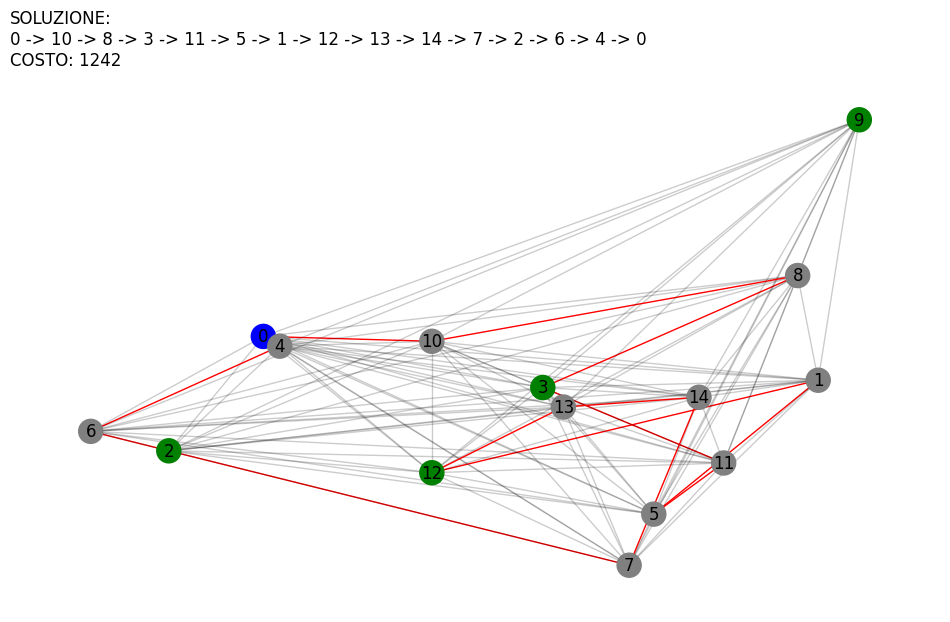

In [169]:
#RICHIEDE L'ESECUZIONE DELLA CELLA PRECEDENTE
import networkx as nx 
import utility_function as uf

#Caricamento del grafo da file
#scelta istanza
graph_file = "istances/graph.gml"
batteria_max = 150

#lettura grafo
G = nx.read_gml(graph_file, destringizer=int)

#applicazione algoritmo
soluzione, batteria_per_nodo = greedy_random_insertion_colonnine(G,batteria_max)

#controllo se la soluzione siste
if soluzione == None:
    print("soluzione non trovata. Batteria insufficiente per raggiungere tutti i clienti")
else:
    print("soluzione trovata:")
    print(soluzione)
    
    print("batteria_per_nodo:")
    print(batteria_per_nodo)

    costo = uf.costo(G, soluzione, batteria_per_nodo)
    print("costo: ", costo)

    #plot the solution
    uf.draw_solution(G, soluzione , costo)


### Cheapest Insertion 
1. Parto sempre dal deposito e un cliente con l'arco più corto, ovvero quello che minimizza d(i, j) con i = 0 e j un cliente. **CONTROLLO:** devo poter raggiungere una colonnina arrivata a j.
2. Trovo il cliente il cui inserimento nel tour causa il minore aumento di lunghezza, ovvero il cliente k che minimizza d(i, k) + d(k, j) - d(i, j) con (i, j) un arco nel tour parziale. K potrebbe anche essere una colonnina.
3. Inserisco k tra i e j.
4. Ripeto fino a che non ho inserito tutti i clienti.    
5. Devo terminare in D.


In [3]:
import networkx as nx
import utility_function as uf

def greedy_cheapest_insertion(G : nx.Graph, batteria_max : int):
        #inizializzazione liste dal grafo di partenza
        clienti = [node for node in G.nodes if G.nodes[node]['type'] == "cliente"]
        collonnine = [node for node in G.nodes if G.nodes[node]['type'] == "colonnina"]

        nodo_attuale = 0
        nodi_da_visitare = clienti.copy() #devo anche tornare al deposito quindi lo devo visitare una seconda volt  
        batteria_per_nodo = [batteria_max] #per ogni nodo della soluzione salvo la batteria rimanente ()

        soluzione_trovata = True

        #inizializzazione soluzione
        
        # inizio il tour dal deposito 
        tour = [nodo_attuale]
        #print(nodi_da_visitare)
        # trovo il nodo più vicino al deposito
        first_best = uf.get_nearest_node(G, nodo_attuale, nodi_da_visitare)
        # aggiungo il nodo alla soluzione
        #first_best è una tupla (dist, nodo)
        tour.append(first_best[1])
        tour.append(0)
        nodi_da_visitare.remove(first_best[1])
                
        while len(nodi_da_visitare) > 0:
                
                best_inserzione = (int(1000000000),0)
                # funzione che per ogni coppia di nodi in tour trova il nodo più vicino e lo inserisce
                for i in range(len(tour)-1):
                        
                        #prendo a due a due i nodi in tour 
                        nodo_attuale = tour[i]
                        nodo_successivo = tour[i+1]

                        #trovo il nodo più vicino a nodo_attuale e nodo_successivo
                        inserzione = uf.cheapest_deviation(G, nodo_attuale, nodo_successivo, nodi_da_visitare)
                        #coppia costo totale deviazione e nodo da cui passare
                        
                        if inserzione[0] < best_inserzione[0]:
                                best_inserzione = inserzione
                                best_inserzione_index = i+1
                                

                #inserisco il nodo nella soluzione
                tour.insert(best_inserzione_index,best_inserzione[1])
                nodi_da_visitare.remove(best_inserzione[1])
                #print(tour)

        for j in range(1,len(tour)):
                batteria =batteria_per_nodo[j-1]- G[tour[j-1]][tour[j]]['weight'] 
                batteria_per_nodo.append(batteria)

        return tour, batteria_per_nodo   





In [25]:
import networkx as nx
import utility_function as uf

def add_colonnina_rapporto(G : nx.graph, tour : list,  batteria_per_nodo : list, batteria_max : int):
        #provo tutte le colonnine che non sono nel tour
        colonnine = [node for node in G.nodes if G.nodes[node]['type'] == "colonnina"]
        #clienti = [node for node in G.nodes if G.nodes[node]['type'] == "cliente"]

        best_ratio = 0
        for j in range(0,len(tour)-1): #i nodo batteria negativa
                #prendo a due a due i nodi in tour 
                nodo_attuale = tour[j]
                nodo_successivo = tour[j+1]

                temp_tour = tour.copy()

                #trovo il nodo più vicino a nodo_attuale e nodo_successivo
                
                costo_inserzione, colonnina = uf.cheapest_deviation(G, nodo_attuale, nodo_successivo, colonnine)
                guadagno_inserzione = batteria_max - batteria_per_nodo[j+1] 
              
                ratio = guadagno_inserzione/costo_inserzione
          
                #aggiungo la colonnina a temp_tour
                temp_tour.insert(j+1,colonnina)
                
                if ratio > best_ratio:
                        #print("best inserzione trovata")
                        best_ratio = ratio
                        best_tour = temp_tour
                        best_batteria_per_nodo = uf.calcolo_batteria_per_nodo(G,best_tour,batteria_max)
        
        return best_tour, best_batteria_per_nodo
                

def add_colonnine_to_tour_rapporto(G : nx.Graph, tour : list, batteria_per_nodo : list, batteria_max : int):
    #controllo che ci sia un valore di batteria per ogni nodo del tour
    if(len(batteria_per_nodo) != len(tour)):
        print("errore: lunghezza batteria per nodo diversa da lunghezza tour")
        return None

    #finchè la soluzione non diventa ammissibile
    while uf.check_batteria_negativa(batteria_per_nodo) == True:
        tour, batteria_per_nodo = add_colonnina_rapporto(G, tour, batteria_per_nodo, batteria_max)

    return tour, batteria_per_nodo

def add_colonnine_to_tour_reverse(G : nx.Graph, tour : list, batteria_per_nodo : list, batteria_max : int):
        #controllo che ci sia un valore di batteria per ogni nodo del tour
        if(len(batteria_per_nodo) != len(tour)):
                print("errore: lunghezza batteria per nodo diversa da lunghezza tour")
                return None
        #scorro la lista finché nessun tratto sia negativo
        while(uf.check_batteria_negativa(batteria_per_nodo) == True):
              

                for i in range(len(tour)):
                #for i in range(0,len(tour)):
                       
                        if(batteria_per_nodo[i] < 0):
                             
                                #devo aggiungere una colonnina prima di tour[i]
                                tour, batteria_per_nodo = add_colonnina_before_i(G, tour, batteria_max, i)
                                
                                break
        return tour, batteria_per_nodo


def add_colonnina_before_i(G : nx.graph, tour : list, batteria_max : int, i : int):
        colonnine = [node for node in G.nodes if G.nodes[node]['type'] == "colonnina"]
        best_inserzione = (int(1000000000),0)
        for j in range(0,i): #i nodo batteria negativa
                        
                #prendo a due a due i nodi in tour 
                nodo_attuale = tour[j]
                nodo_successivo = tour[j+1]

                temp_tour = tour.copy()

                #trovo il nodo più vicino a nodo_attuale e nodo_successivo
                inserzione = uf.cheapest_deviation(G, nodo_attuale, nodo_successivo, colonnine)
                #print("inserisco fra ", nodo_attuale, " e ", nodo_successivo, "colonnina:" , inserzione[1])
                temp_tour.insert(j+1,inserzione[1])
                batteria_per_nodo_temp = uf.calcolo_batteria_per_nodo(G,temp_tour,batteria_max)
                #coppia costo totale deviazione e nodo da cui passare
            
               
                #print("batteria per nodo temp: ", batteria_per_nodo_temp)
                
                if inserzione[0] < best_inserzione[0] and batteria_per_nodo_temp[i+1] > 0:
                       
                        best_inserzione = inserzione
                        best_tour = temp_tour
                        best_batteria_per_nodo = batteria_per_nodo_temp
        
        return best_tour, best_batteria_per_nodo


soluzione trovata:
[0, 28, 12, 29, 20, 24, 8, 7, 4, 6, 9, 17, 11, 18, 13, 3, 5, 4, 25, 22, 27, 16, 23, 26, 2, 26, 10, 15, 19, 0]
batteria_per_nodo:
[250, 206.0910031997997, 193.284754724934, 250, 216.89410928550632, 172.17274973551054, 101.84494584544157, 51.35732359998422, 250, 212.1450135385046, 167.23399039273335, 250, 240.7804555427071, 187.62032010269905, 151.49553636632217, 250, 219.91678208701734, 250, 203.9348287748759, 174.10196099452332, 118.94763206197263, 96.58695228697474, 30.10387173259609, 250, 215.07150160685404, 250, 202.49210591912117, 148.28878498765056, 125.92810521265267, 43.05470779225003]
costo:  1905
costo1:  1936


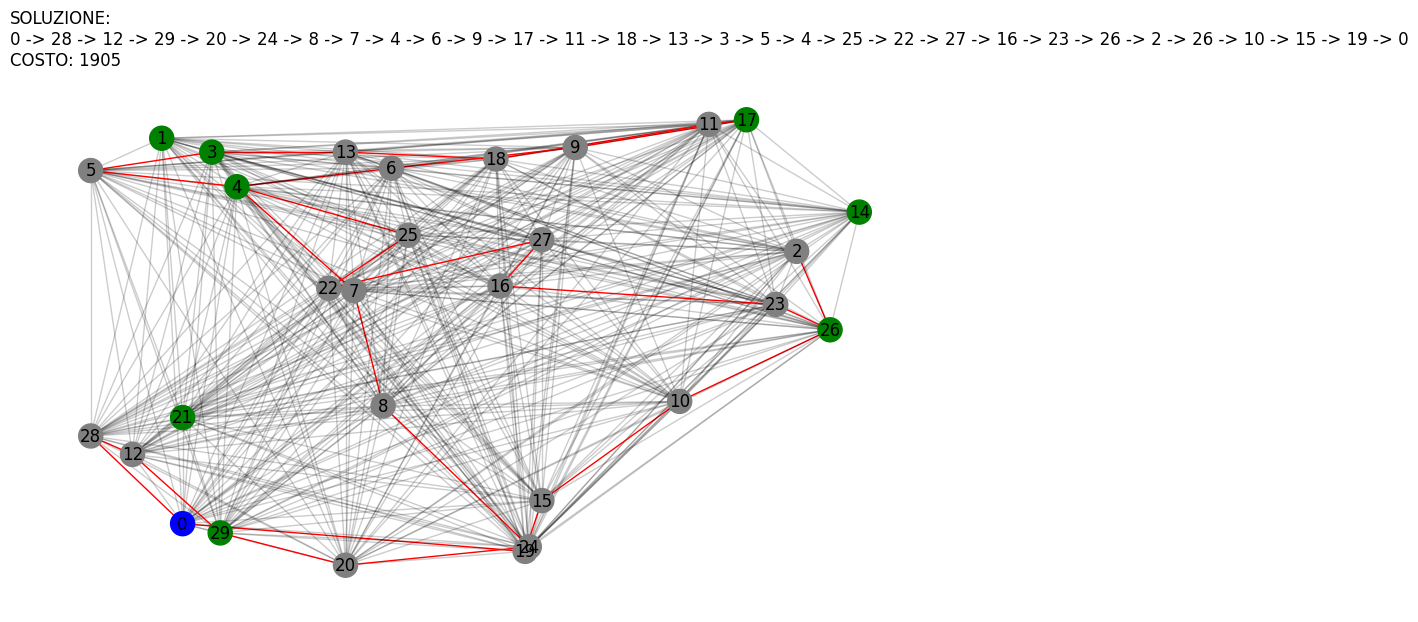

In [26]:
#RICHIEDE L'ESECUZIONE DELLA CELLA PRECEDENTE
import networkx as nx 
import utility_function as uf

#Caricamento del grafo da file
#scelta istanza

graph_file = "istances/USA.gml"
batteria_max = 250

#lettura grafo
G = nx.read_gml(graph_file, destringizer=int)

#applicazione algoritmo
soluzione, batteria_per_nodo = greedy_cheapest_insertion(G,batteria_max)

#aggiungiamo le colonnine necessarie
soluzione1, batteria_per_nodo1 = uf.add_colonnine_to_tour(G, soluzione, batteria_per_nodo, batteria_max)
soluzione, batteria_per_nodo = add_colonnine_to_tour_reverse(G, soluzione, batteria_per_nodo, batteria_max)


#controllo se la soluzione siste
if soluzione == None:
    print("soluzione non trovata. Batteria insufficiente per raggiungere tutti i clienti")
else:
    print("soluzione trovata:")
    print(soluzione)
    
    print("batteria_per_nodo:")
    print(batteria_per_nodo)

    costo = uf.costo(G,soluzione, batteria_per_nodo)
    costo1 = uf.costo(G,soluzione1, batteria_per_nodo1)
   
    #costo = uf.costo(G, soluzione, batteria_per_nodo)
    print("costo: ", costo)
    print("costo1: ", costo1)

    #plot the solution
    uf.draw_solution(G, soluzione , costo)

In [ ]:
import networkx as nx
import utility_function as uf

#RICHIEDE L'ESECUZIONE DELLA CELLA PRECEDENTE
import networkx as nx 
import utility_function as uf

#Caricamento del grafo da file
#scelta istanza
graph_file = "istances/graph.gml"
batteria_max = 150

#lettura grafo
G = nx.read_gml(graph_file, destringizer=int)

#applicazione algoritmo
soluzione, batteria_per_nodo = greedy_cheapest_insertion(G,batteria_max)
        
        
        

### Farthest Insertion
Questa euristica inizia con un percorso contenente un solo punto. In ogni passo, trova il punto non ancora incluso nel percorso che è il più lontano da ogni punto esistente nel percorso e richiede il minor costo per essere inserito. Questo processo viene ripetuto fino a quando tutti i punti non sono stati inseriti.

In [6]:
import networkx as nx 
import utility_function as uf

def greedy_farthest_insertion(G : nx.Graph, batteria_max : int):
    
    clienti = [node for node in G.nodes if G.nodes[node]['type'] == "cliente"]
    collonnine = [node for node in G.nodes if G.nodes[node]['type'] == "colonnina"]

    #inizializzazione
    nodo_attuale = 0
    batteria = batteria_max
    nodi_visitati = []
    nodi_da_visitare = clienti.copy() #devo anche tornare al deposito quindi lo devo visitare una seconda volta
    soluzione = [0]
    colonnine_visitate = [] #per evitare cicli
    batteria_per_nodo = [batteria_max] #per ogni nodo della soluzione salvo la batteria rimanente ()

    tour = []
    soluzione_trovata = True
    farthest_node = (0,0)
    
    #inizializzazione soluzione
        
        # inizio il tour dal deposito 
    tour = [nodo_attuale]
    #print(nodi_da_visitare)
    # trovo il nodo più vicino al deposito
    first_best = uf.get_farthest_node(G, nodo_attuale, nodi_da_visitare)
    # aggiungo il nodo alla soluzione
    #first_best è una tupla (dist, nodo)
    tour.append(first_best[1])
    tour.append(0)
    nodi_da_visitare.remove(first_best[1])

    
    
     #controllo se ci posso arrivare
    while len(nodi_da_visitare) > 0:

        #print("nodi da visitare:", nodi_da_visitare)
        farthest_node = (int(0),0)
        
        #prendo il nodo più lontano dal tour 
        for i in tour:
            far_node = uf.get_farthest_node(G, i, nodi_da_visitare)
            #print("farnode", far_node)
            if far_node[0] > farthest_node[0]:
                farthest_node = far_node

        #print("nodo farthest:",farthest_node[1])
        best_inserzione = (int(100000000),0)
        for i in range(len(tour)-1):
                        
            #prendo a due a due i nodi in tour 
            nodo_attuale = tour[i]
            nodo_successivo = tour[i+1]

            #costo deviazione da i a nodo nuovo piu da nodo nuovo a i+1
            inserzione = G[nodo_attuale][int(farthest_node[1])]['weight'] + G[int(farthest_node[1])][nodo_successivo]['weight']
            #coppia costo totale deviazione e nodo da cui passare
            
            if inserzione < best_inserzione[0]:
                    best_inserzione = ( inserzione, farthest_node[1])
                    best_inserzione_index = i+1
                                

        #inserisco il nodo nella soluzione
        tour.insert(best_inserzione_index,best_inserzione[1])
        nodi_da_visitare.remove(best_inserzione[1])
        
       # print("Inserito:",farthest_node[1])
       # print("tour:", tour)

        batteria_per_nodo = uf.calcolo_batteria_per_nodo(G,tour,batteria_max)
                            
        #check if the battery is enough to go to the farthest node and to reach the farthest charging station
        if batteria_per_nodo[best_inserzione_index] - uf.get_nearest_node(G, farthest_node[1], collonnine)[0] < 0:
    
           # print("serve una colonnina prima di: " , tour[best_inserzione_index])

            #go to the nearest charging station
            nodo_colonnina = uf.cheapest_deviation(G, tour[best_inserzione_index-1], tour[best_inserzione_index], collonnine) #la colonnina più vicina
         

            #aggiornamento dello stato
            tour.insert(best_inserzione_index,nodo_colonnina[1])
            #print("aggiunta colonnina.", nodo_colonnina[1], "Tour:", tour)
        
        #nodi_visitati.append(farthest_node[1])
        #nodo_attuale = nodo_colonnina[1]
       

    return tour, batteria_per_nodo
    


### Christofides

[150, 107.04653681017095, 63.62995011798613, 61.39388214048634, 41.17013372432966, 150, 101.74028595194538, 150, 81.39970845543002, 150, 103.93482877487591, 72.82213040266782, 50.461450627669926, 150, 100.80650449500462, 150, 112.1450135385046, 150, 102.49210591912119, 150, 132.9706136340736, 150, 115.07150160685404, 150, 114.3068634048505, 150, 118.0, 81.87521626362312, 62.22833355923461, 150, 140.7804555427071, 150, 126.59060017856075, 150, 130.0]


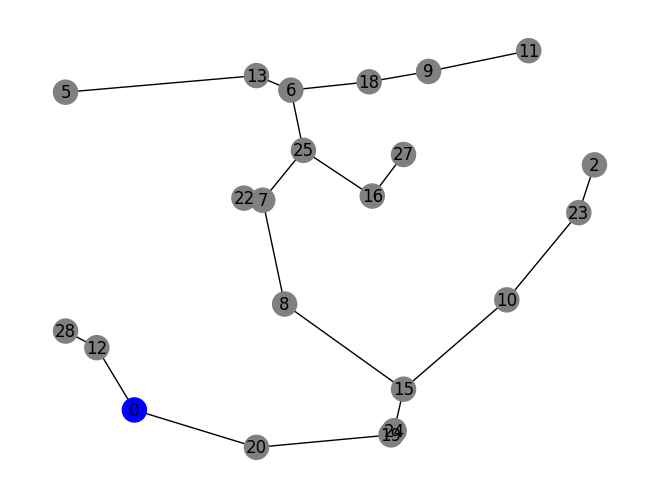

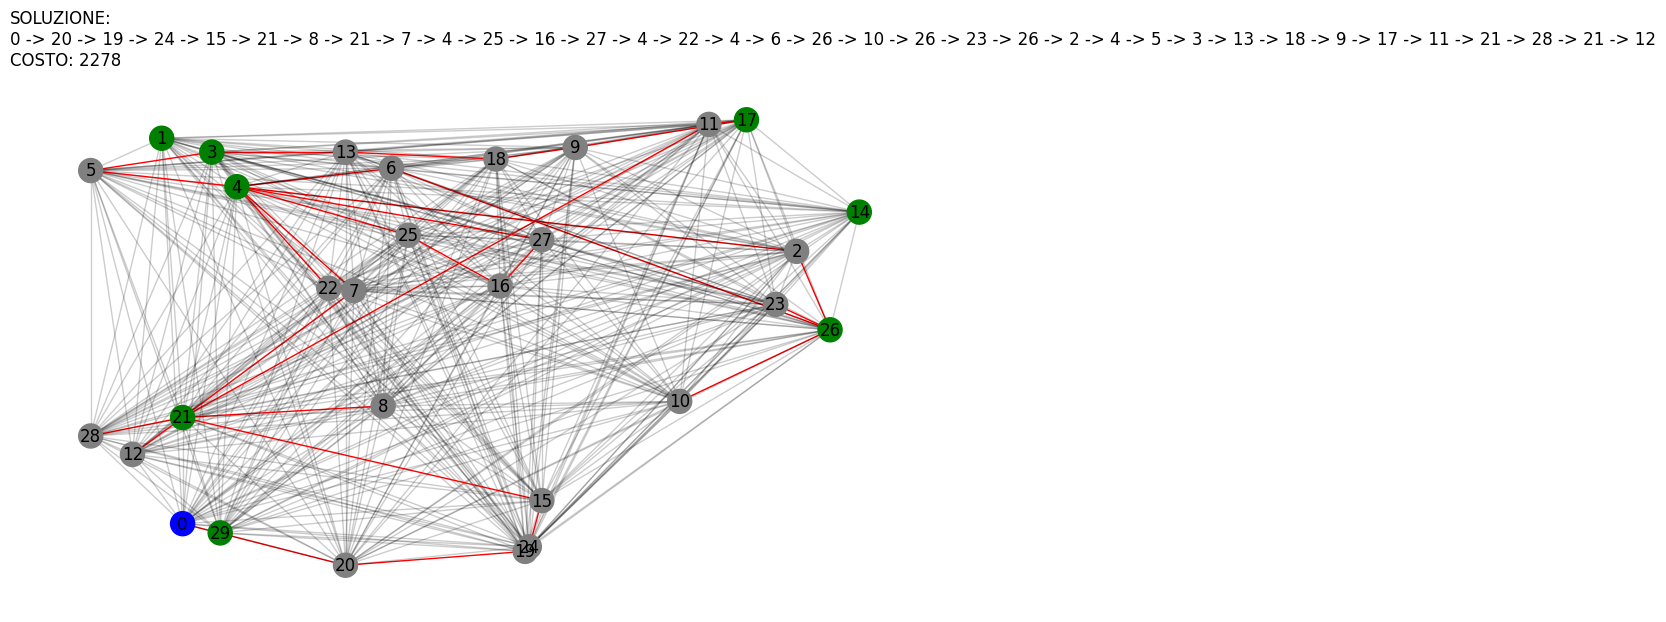

In [7]:
import networkx as nx
#from networkx.algorithms.approximation import minimum_spanning_tree
from networkx.algorithms.euler import eulerian_circuit
#from networkx.algorithms.shortest_paths import pairwise

def christofides_tsp(G):
    G_clienti = G.copy()
    G_clienti.remove_nodes_from([node for node in G.nodes if G.nodes[node]['type'] == "colonnina"])
    # Step 1: Calcola il Minimum Spanning Tree
    T = nx.minimum_spanning_tree(G_clienti)

    # Step 2: Calcola il set di nodi di grado dispari
    nodi_dispari = [nodo for nodo, grado in T.degree() if grado % 2 == 1]

    # Step 3: Calcola il Minimum Weight Perfect Matching sui nodi di grado dispari
    G_dispari = G_clienti.subgraph(nodi_dispari)
    M = nx.algorithms.matching.max_weight_matching(G_dispari)

    # Step 4: Unisci il Minimum Spanning Tree e il Minimum Weight Perfect Matching
    H = nx.MultiGraph(T)
    uf.draw_graph(H)
    for u, v in M:
        H.add_edge(u, v)
   

    # Step 5: Calcola un circuito euleriano sul grafo ottenuto
    circuito_euleriano = list(eulerian_circuit(H))

    # Step 6: Rimuovi i nodi duplicati dal circuito euleriano
    nodi_visitati = set()
    circuito_tsp = []
    for u, v in circuito_euleriano:
        if u not in nodi_visitati:
            circuito_tsp.append(u)
            nodi_visitati.add(u)
        if v not in nodi_visitati:
            circuito_tsp.append(v)
            nodi_visitati.add(v)


    return circuito_tsp

batteria_max=150

#remove colonnine from G
G = nx.read_gml("istances/USA.gml", destringizer=int)


soluzione = christofides_tsp(G)

#solo per christo
batteria_per_nodo = uf.calcolo_batteria_per_nodo(G, soluzione, batteria_max)
nuova_soluzione, batteria_per_nodo_nuova = uf.add_colonnine_to_tour(G,soluzione,batteria_per_nodo,batteria_max)
costo = uf.costo(G, nuova_soluzione, batteria_per_nodo_nuova)
print(batteria_per_nodo_nuova)


uf.draw_solution(G, nuova_soluzione, costo)


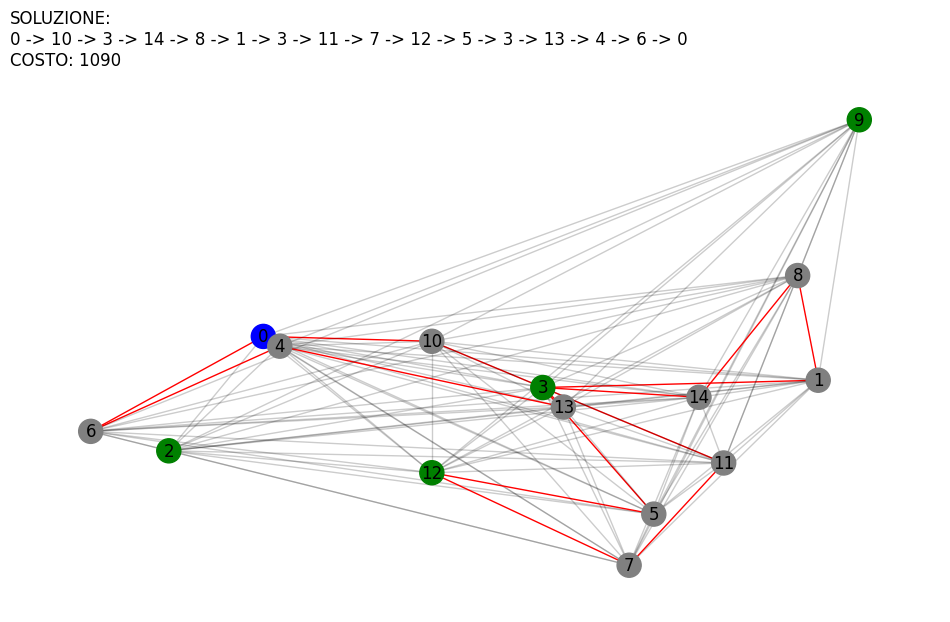

In [ ]:


#RICHIEDE L'ESECUZIONE DELLA CELLA PRECEDENTE
import networkx as nx 
import utility_function as uf


#Caricamento del grafo da file
#scelta istanza
graph_file = "istances/graph.gml"
batteria_max = 200

#lettura grafo
G = nx.read_gml(graph_file, destringizer=int)

#applicazione algoritmo
soluzione, batteria_per_nodo = greedy_cheapest_insertion(G,batteria_max)

#aggiungiamo le colonnine necessarie
soluzione, batteria_per_nodo = uf.add_colonnine_to_tour(G, soluzione, batteria_per_nodo, batteria_max)

costo = uf.costo(G,soluzione, batteria_per_nodo)

#costo = uf.costo(G, soluzione, batteria_per_nodo)
#print("costo: ", costo)

#plot the solution
uf.draw_solution(G, soluzione , costo)

## Local search

Data una soluzione ottenuta da algoritmo greedy, si cerca di migliorarla usando la ricerca locale.

### City Swap

Data la soluzione nello forma di vettore di nodi visitati (in ordine) l'intorno è dato da tutte le soluzioni che si ottengono scambiando due nodi. Ci si ferma se non di in grado di determinare una soluzione migliore di quella attuale.

In [33]:
import networkx as nx
import utility_function as uf

def city_swap(G : nx.Graph, soluzione : list, batteria_per_nodo : list):
    
    batteria_max = batteria_per_nodo[0]

    soluzione_attuale = soluzione
    costo_attuale = uf.costo(G, soluzione_attuale, batteria_per_nodo)

    #scorro la soluzione (escluso il primo nodo e ultimo nodo)
    for i in range(1,len(soluzione)-1):
        #scorro la soluzione (escluso il primo nodo e ultimo nodo)
        for j in range(i+1,len(soluzione)-1):
           
            #scambio i e j
            nuova_soluzione = soluzione_attuale.copy()
            nuova_soluzione[i], nuova_soluzione[j] = nuova_soluzione[j], nuova_soluzione[i]

            batteria_per_nodo = uf.calcolo_batteria_per_nodo(G,nuova_soluzione,batteria_max)
            #print(nuova_soluzione)

            #controllo se la batteria è negativa (altrimenti soluzione non ammissibile)
            if uf.check_batteria_negativa(batteria_per_nodo) == True:
                #print("batteria negativa")
                nuova_soluzione, batteria_per_nodo= uf.add_colonnine_to_tour(G,nuova_soluzione,batteria_per_nodo,batteria_per_nodo[0])
                

            costo_nuova_soluzione = uf.costo(G, nuova_soluzione, batteria_per_nodo)
            #print("swap",i,j,costo_nuova_soluzione)
            #se il costo è minore allora aggiorno la soluzione
            if costo_nuova_soluzione < costo_attuale:
                #print("city swap: first improvment, costo =  ", costo_nuova_soluzione)
                soluzione_attuale = nuova_soluzione
                costo_attuale = costo_nuova_soluzione

                return soluzione_attuale, batteria_per_nodo
    
    batteria_per_nodo = uf.calcolo_batteria_per_nodo(G,soluzione_attuale,batteria_max)
    return soluzione_attuale, batteria_per_nodo
    

def local_city_swap(G : nx.Graph, soluzione : list, batteria_per_nodo : list):
    migliorato = True

    soluzione_attuale = soluzione.copy()
    batteria_per_nodo_attuale = batteria_per_nodo.copy()

    while migliorato:
        soluzione_nuova, batteria_per_nodo_nuova = city_swap(G, soluzione_attuale, batteria_per_nodo_attuale)

        costo = uf.costo(G,soluzione_nuova,batteria_per_nodo_nuova)
        
        
        if soluzione_nuova == soluzione or uf.costo(G,soluzione_nuova,batteria_per_nodo_nuova) == uf.costo(G,soluzione_attuale,batteria_per_nodo_attuale):
            migliorato = False
        
        soluzione_attuale = soluzione_nuova
        batteria_per_nodo_attuale = batteria_per_nodo_nuova

    #print("return costo city swap:",costo)
    return soluzione_nuova, batteria_per_nodo_nuova

COSTO VECCCHIO:  1936
soluzione migliore trovata, con costo:  1925
1925
soluzione migliore trovata, con costo:  1913
1913


soluzione migliore trovata, con costo:  1898
1898
soluzione migliore trovata, con costo:  1877
1877
soluzione migliore trovata, con costo:  1875
1875
soluzione migliore trovata, con costo:  1848
1848
soluzione migliore trovata, con costo:  1809
1809
soluzione migliore trovata, con costo:  1786
1786
soluzione migliore trovata, con costo:  1738
1738
soluzione migliore trovata, con costo:  1722
1722
soluzione migliore trovata, con costo:  1713
1713
soluzione migliore trovata, con costo:  1661
1661
soluzione migliore trovata, con costo:  1652
1652
soluzione migliore trovata, con costo:  1640
1640
1640
soluzione trovata:
[0, 12, 28, 29, 19, 24, 15, 4, 4, 5, 4, 13, 6, 18, 17, 11, 9, 4, 4, 22, 7, 25, 16, 27, 2, 26, 26, 23, 10, 8, 20, 0]
batteria_per_nodo:
[250, 217.68901115719297, 204.88276268232727, 250, 176.56295212905138, 174.32688415155158, 154.1031357353949, 250, 250, 214.3068634048505, 250, 219.98333796039273, 206.94493314998743, 181.6269553476431, 250, 240.7804555427071, 207.2543463142

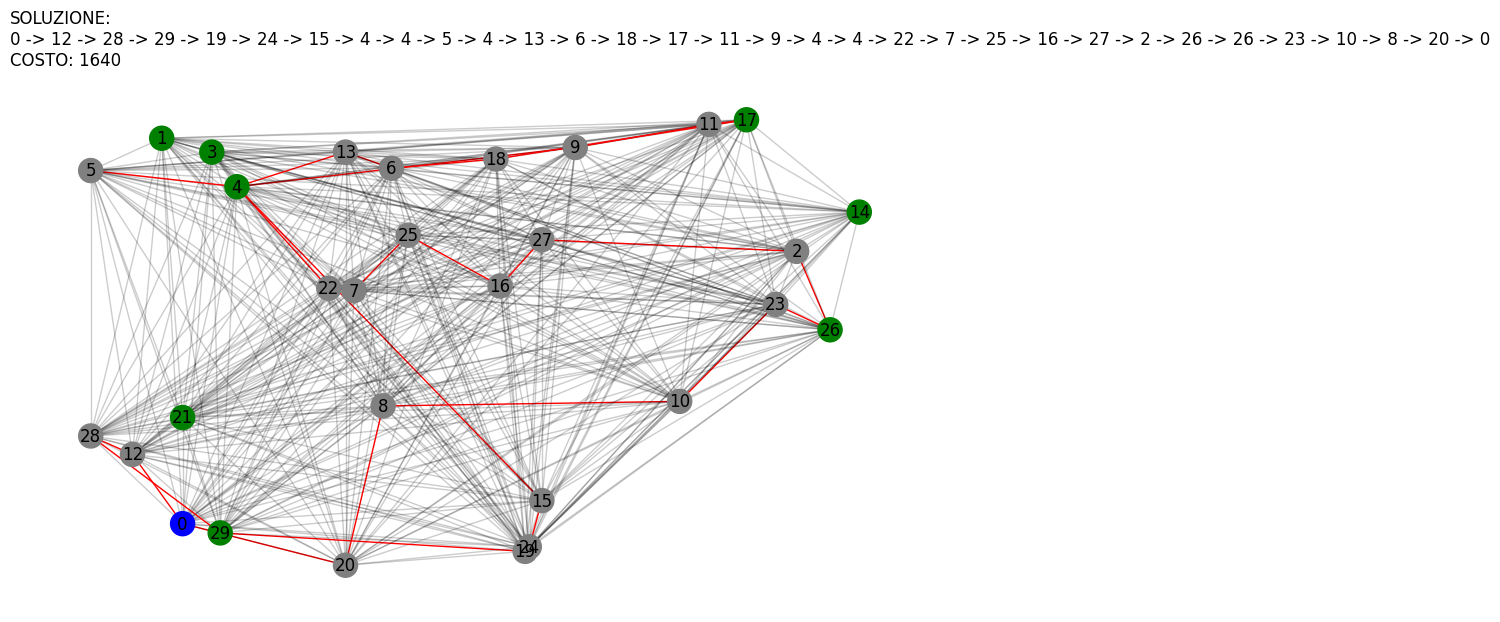

In [184]:
#RICHIEDE L'ESECUZIONE DELLA CELLA PRECEDENTE E DI QUELLA CON LA GREEDY VOLUTA
import networkx as nx 
import utility_function as uf

#Caricamento del grafo da file
#scelta istanza
graph_file = "istances/USA.gml"
batteria_max = 250

#lettura grafo
G = nx.read_gml(graph_file, destringizer=int)

#applicazione algoritmo greedy
soluzione, batteria_per_nodo = greedy_cheapest_insertion(G,batteria_max)

#aggiungiamo le colonnine necessarie per renderla ammissibile
soluzione, batteria_per_nodo = uf.add_colonnine_to_tour(G, soluzione, batteria_per_nodo, batteria_max)

costo= uf.costo(G,soluzione, batteria_per_nodo)
print("COSTO VECCCHIO: ", costo)

#ricerca locale
soluzione, batteria_per_nodo = local_city_swap(G, soluzione, batteria_per_nodo)


#controllo se la soluzione siste
if soluzione == None:
    print("soluzione non trovata. Batteria insufficiente per raggiungere tutti i clienti")
else:
    print("soluzione trovata:")
    print(soluzione)
    
    batteria_per_nodo= uf.calcolo_batteria_per_nodo(G, soluzione, batteria_max)
    print("batteria_per_nodo:")
    print(batteria_per_nodo)

    costo = uf.costo(G,soluzione, batteria_per_nodo)
    print("COSTO NUOVO: ", costo)
   
    #costo = uf.costo(G, soluzione, batteria_per_nodo)
    #print("costo: ", costo)

    #plot the solution
    uf.draw_solution(G, soluzione , costo)

### 2-opt

In [86]:
def two_2opt_swap(path, i, k):
  
    new_path = path[:i] + path[i:k+1][::-1] + path[k+1:]
   
    return new_path

def opt_swap_intorno(G, soluzione, batteria_per_nodo):
    batteria_max = batteria_per_nodo[0]

    soluzione_attuale = soluzione.copy()
    costo_attuale = uf.costo(G, soluzione_attuale, batteria_per_nodo)

    #scorro la soluzione (escluso il primo nodo e ultimo nodo)
    for i in range(1,len(soluzione)-1):
        #scorro la soluzione (escluso il primo nodo e ultimo nodo)
        for j in range(i+2,len(soluzione)-1):

    
            #scambio i e j
            #nuova_soluzione = soluzione_attuale.copy()
            nuova_soluzione = two_2opt_swap(soluzione_attuale, i, j)

            #print(nuova_soluzione)
           
            batteria_per_nodo_nuova = uf.calcolo_batteria_per_nodo(G,nuova_soluzione,batteria_max)

            #controllo se la batteria è negativa (altrimenti soluzione non ammissibile)
            if uf.check_batteria_negativa(batteria_per_nodo_nuova) == True:
                #print("batteria negativa")
                nuova_soluzione, batteria_per_nodo_nuova = uf.add_colonnine_to_tour(G,nuova_soluzione,batteria_per_nodo_nuova,batteria_per_nodo[0])
                
           
            costo_nuova_soluzione = uf.costo(G, nuova_soluzione, batteria_per_nodo_nuova)
           
            #se il costo è minore allora aggiorno la soluzione
            if costo_nuova_soluzione < costo_attuale:
                #print("soluzione migliore trovata, con costo: ", costo_nuova_soluzione, costo_attuale)
                soluzione_attuale = nuova_soluzione
                costo_attuale = costo_nuova_soluzione

                batteria_per_nodo_nuova = uf.calcolo_batteria_per_nodo(G,nuova_soluzione,batteria_max)

                return soluzione_attuale, batteria_per_nodo_nuova
    
    
    batteria_per_nodo_nuova = uf.calcolo_batteria_per_nodo(G,soluzione_attuale,batteria_max)
    return soluzione_attuale, batteria_per_nodo


def local_2opt_swap(G, soluzione, batteria_per_nodo):
    migliorato = True

    soluzione_attuale = soluzione.copy()
    batteria_per_nodo_attuale = batteria_per_nodo.copy()

    while migliorato:
        soluzione_nuova, batteria_per_nodo_nuova = opt_swap_intorno(G, soluzione_attuale, batteria_per_nodo_attuale)
        
        if soluzione_nuova == soluzione or uf.costo(G,soluzione_nuova,batteria_per_nodo_nuova) == uf.costo(G,soluzione_attuale,batteria_per_nodo_attuale):
            migliorato = False
        
        soluzione_attuale = soluzione_nuova
        batteria_per_nodo_attuale = batteria_per_nodo_nuova

    return soluzione_nuova, batteria_per_nodo_nuova

### City insertion

In [4]:
import networkx as nx
import numpy as np
def city_insertion_best_improvement(G : nx.Graph, soluzione : list, batteria_per_nodo : list):

    soluzione_best = soluzione
    batteria_per_nodo_best = batteria_per_nodo
    costo_best = uf.costo(G,soluzione,batteria_per_nodo)

       #scorro la soluzione (escluso il primo nodo e ultimo nodo)
    for i in range(1,len(soluzione)-1):
        #scorro la soluzione (escluso il primo nodo e ultimo nodo)
        for j in range(i+1,len(soluzione)-1):

            soluzione_temp = soluzione.copy()

            #rimuovo il nodo i-esimo
            soluzione_temp.remove(soluzione[i])
            #lo riposizioni in posizione j-esima
            soluzione_temp.insert(j,soluzione[i])

            #calcolo il costo della nuova soluzione
            batteria_per_nodo_temp = uf.calcolo_batteria_per_nodo(G,soluzione_temp,batteria_per_nodo[0])
            costo_temp = uf.costo(G,soluzione_temp,batteria_per_nodo_temp)

            if uf.check_batteria_negativa(batteria_per_nodo_temp) == False:
                if costo_temp < costo_best:
                    print("Improvement trovato", costo_temp)
                    #print(batteria_per_nodo_temp)
                    costo_best = costo_temp
                    soluzione_best = soluzione_temp
                    batteria_per_nodo_best = batteria_per_nodo_temp
   
    return soluzione_best, batteria_per_nodo_best


def local_city_insertion(G : nx.Graph, soluzione : list, batteria_per_nodo : list):
    migliorato = True

    soluzione_attuale = soluzione.copy()
    batteria_per_nodo_attuale = batteria_per_nodo.copy()

    while migliorato:
        soluzione_nuova, batteria_per_nodo_nuova = city_insertion_best_improvement(G, soluzione_attuale, batteria_per_nodo_attuale)
        
        if soluzione_nuova == soluzione or uf.costo(G,soluzione_nuova,batteria_per_nodo_nuova) == uf.costo(G,soluzione_attuale,batteria_per_nodo_attuale):
            migliorato = False
        
        soluzione_attuale = soluzione_nuova
        batteria_per_nodo_attuale = batteria_per_nodo_nuova

    return soluzione_nuova, batteria_per_nodo_nuova


### 3-opt

In [ ]:
import itertools
import utility_function as uf


def intorno3opt(G,soluzione,batteria_per_nodo):
    #inizializzazione
    batteria_max = batteria_per_nodo[0]
    best_cost = uf.costo(G,soluzione, batteria_per_nodo)


    allcombinantions = list(itertools.permutations(range(1, len(soluzione)-1),3))

    for lista_taglio in allcombinantions:
        sol_list = uf.generate_combination(soluzione, lista_taglio)

        best_in_list=100000000
        best_sol = None

        #cerchiamo in sol_list la soluzione migliore
        for i in sol_list:
            
            batteria_per_nodo = uf.calcolo_batteria_per_nodo(G, i, batteria_max)
            costo = uf.costo(G,i, batteria_per_nodo)
            batteria_per_nodo_temp = uf.calcolo_batteria_per_nodo(G, i, batteria_max)
            if costo < best_in_list and uf.check_batteria_negativa(batteria_per_nodo_temp) == False:
                #print(i)
                best_in_list = costo
                best_sol = i
                batteria_per_nodo_list = batteria_per_nodo_temp

        #print("Best in list: ", best_in_list)
        
        if best_in_list < best_cost:
            #print("Trovata soluzione migliore", best_in_list)
            best_cost = best_in_list
            soluzione = best_sol
            batteria_per_nodo = batteria_per_nodo_list

        
    return soluzione, batteria_per_nodo

def local_3opt(G,soluzione,batteria_per_nodo):
    migliorato = True

    soluzione_attuale = soluzione.copy()
    batteria_per_nodo_attuale = batteria_per_nodo.copy()

    while migliorato:
        print("miglioro")
        soluzione_nuova, batteria_per_nodo_nuova = intorno3opt(G, soluzione_attuale, batteria_per_nodo_attuale)
        
        if soluzione_nuova == soluzione or uf.costo(G,soluzione_nuova,batteria_per_nodo_nuova) == uf.costo(G,soluzione_attuale,batteria_per_nodo_attuale):
            migliorato = False
        
        soluzione_attuale = soluzione_nuova
        batteria_per_nodo_attuale = batteria_per_nodo_nuova

    return soluzione_nuova, batteria_per_nodo_nuova
    
        

COSTO VECCCHIO:  2215
Improvement trovato 2204
Improvement trovato 2124
Improvement trovato 2056
Improvement trovato 2045
Improvement trovato 1966
Improvement trovato 1955
Improvement trovato 1913
Improvement trovato 1896
Improvement trovato 1883
Improvement trovato 1872
Improvement trovato 1868
Improvement trovato 1838
Improvement trovato 1827
Improvement trovato 1823
Improvement trovato 1805
Improvement trovato 1798
Improvement trovato 1788
Improvement trovato 1783
Improvement trovato 1765
Improvement trovato 1754
Improvement trovato 1750
Improvement trovato 1740
Improvement trovato 1726
Improvement trovato 1715
Improvement trovato 1674
Improvement trovato 1663
Improvement trovato 1650
Improvement trovato 1639
Improvement trovato 1579
Improvement trovato 1560
Improvement trovato 1556
COSTO NUOVO:  1556
[150, 117.68901115719298, 104.88276268232728, 150, 101.74028595194538, 150, 140.7804555427071, 107.25434631422668, 87.60746360983818, 62.28948580749385, 49.25108099708855, 150, 119.916

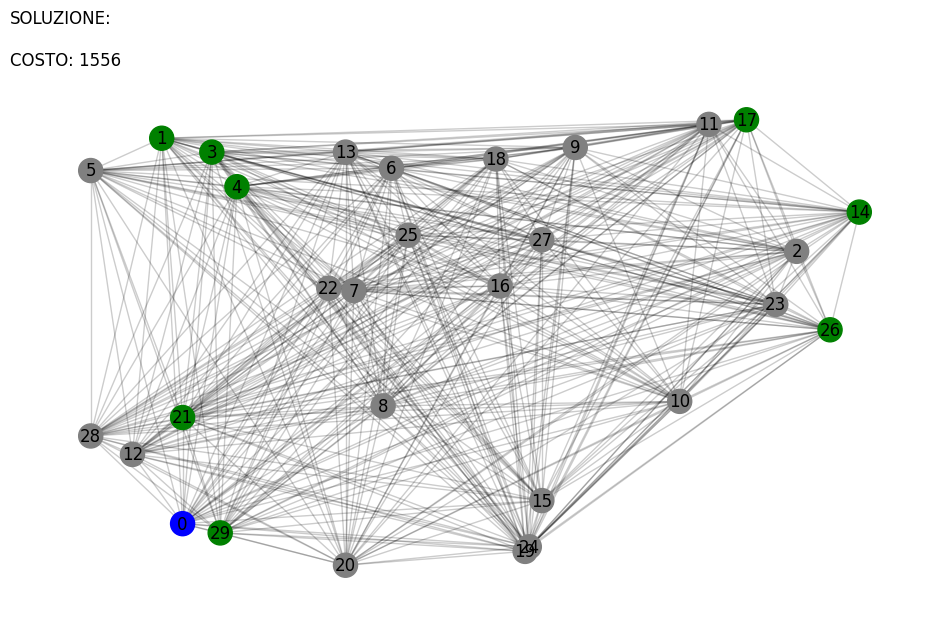

In [7]:
import itertools
import networkx as nx 
import utility_function as uf

#Caricamento del grafo da file
#scelta istanza
graph_file = "istances/USA.gml"
batteria_max = 150

#lettura grafo
G = nx.read_gml(graph_file, destringizer=int)

#applicazione algoritmo greedy
soluzione, batteria_per_nodo = greedy_cheapest_insertion(G,batteria_max)

#aggiungiamo le colonnine necessarie per renderla ammissibile
soluzione, batteria_per_nodo = uf.add_colonnine_to_tour(G, soluzione, batteria_per_nodo, batteria_max)

costo= uf.costo(G,soluzione, batteria_per_nodo)
print("COSTO VECCCHIO: ", costo)


soluzione, batteria_per_nodo = local_city_insertion(G, soluzione, batteria_per_nodo)
costo= uf.costo(G,soluzione, batteria_per_nodo)

print("COSTO NUOVO: ", costo)

print(batteria_per_nodo)
print(soluzione)

uf.draw_solution(G, "", costo)



## Meta-euristiche

### Tabu search

Che come tutti sanno deriva dal Tongano lingua della polinesia e significa "che è proibito" o "che è tabù".

In [ ]:
import itertools
import utility_function as uf


def tabu_intorno3opt(G,soluzione,batteria_per_nodo, tabu_list):
    #inizializzazione
    batteria_max = batteria_per_nodo[0]
    best_cost = uf.costo(G,soluzione, batteria_per_nodo)


    allcombinantions = list(itertools.permutations(range(1, len(soluzione)-1),3))

    for lista_taglio in allcombinantions:
        sol_list = uf.generate_combination(soluzione, lista_taglio)

        best_in_list=100000000
        best_sol = None

        #cerchiamo in sol_list la soluzione migliore
        for i in sol_list:
            
            batteria_per_nodo = uf.calcolo_batteria_per_nodo(G, i, batteria_max)
            costo = uf.costo(G,i, batteria_per_nodo)
            batteria_per_nodo_temp = uf.calcolo_batteria_per_nodo(G, i, batteria_max)
            if costo < best_in_list and uf.check_batteria_negativa(batteria_per_nodo_temp) == False and i not in tabu_list:
                #print(i)
                best_in_list = costo
                best_sol = i
                batteria_per_nodo_list = batteria_per_nodo_temp

        #print("Best in list: ", best_in_list)
        
        if best_in_list < best_cost:
            #print("Trovata soluzione migliore", best_in_list)
            best_cost = best_in_list
            soluzione = best_sol
            batteria_per_nodo = batteria_per_nodo_list

        
    return soluzione, batteria_per_nodo

def tabu_3opt(G,soluzione,batteria_per_nodo, tabu_list_len, max_iter):
    
    iter_no_improvement = 0
    tabu_list = [soluzione]

    best_soluzione = soluzione
    best_batteria_per_nodo = batteria_per_nodo
    best_cost = uf.costo(G,soluzione, batteria_per_nodo)

    while iter_no_improvement < max_iter:
        print("Iterazione: ", iter_no_improvement)
        soluzione_nuova, batteria_per_nodo_nuova = tabu_intorno3opt(G, soluzione, batteria_per_nodo, tabu_list)
        
        costo_temp = uf.costo(G,soluzione_nuova, batteria_per_nodo_nuova)
        soluzione = soluzione_nuova
        batteria_per_nodo = batteria_per_nodo_nuova

        tabu_list.append(soluzione)

        if len(tabu_list) > tabu_list_len:
            tabu_list.pop(0)


        if costo_temp < best_cost:
            best_cost = costo_temp
            best_soluzione = soluzione
            best_batteria_per_nodo = batteria_per_nodo
            iter_no_improvement = 0
        else:
            soluzione = soluzione_nuova
            batteria_per_nodo = batteria_per_nodo_nuova
            iter_no_improvement += 1
            
       
    return best_soluzione, best_batteria_per_nodo
    

### Tabu search pro max

In attesa di un nome migliore

In [77]:
def two_2opt_swap(path, i, k):
  
    new_path = path[:i] + path[i:k+1][::-1] + path[k+1:]
   
    return new_path

def tabu_intorno2opt_mossevietate(G,soluzione,batteria_per_nodo, tabu_list, moltiplicatore):
    mossa = None
    mossa_best = None
    batteria_max = batteria_per_nodo[0]

    soluzione_attuale = soluzione.copy()
    costo_attuale = uf.costo(G, soluzione_attuale, batteria_per_nodo)
    print("costo attuale: ", costo_attuale)

    #scorro la soluzione (escluso il primo nodo e ultimo nodo)
    for i in range(1,len(soluzione)-1):
        #scorro la soluzione (escluso il primo nodo e ultimo nodo)
        for j in range(i+2,len(soluzione)-1):

            if [i,j] in tabu_list or [j,i] in tabu_list:
                continue
            #scambio i e j
            #nuova_soluzione = soluzione_attuale.copy()
            mossa = [i,j]
           
            nuova_soluzione = two_2opt_swap(soluzione_attuale, i, j)

            #print(nuova_soluzione)
        
            batteria_per_nodo_nuova = uf.calcolo_batteria_per_nodo(G,nuova_soluzione,batteria_max)
            costo_nuova_soluzione = uf.costo(G, nuova_soluzione, batteria_per_nodo_nuova)

            #controllo se la batteria è negativa (altrimenti soluzione non ammissibile)
            if uf.check_batteria_negativa(batteria_per_nodo_nuova) == True:
                #la devo penalizzare
                
                costo_nuova_soluzione = costo_nuova_soluzione + penalizza_non_ammissibile(batteria_per_nodo_nuova, moltiplicatore)
                #print("penalizzo", moltiplicatore, costo_nuova_soluzione)
                amm = False
            else:
                amm = True
        
            #se il costo è minore allora aggiorno la soluzione
            if costo_nuova_soluzione < costo_attuale:
                #print("soluzione migliore trovata, con costo: ", costo_nuova_soluzione, costo_attuale)
                print("soluzione migliore trovata, con costo: ", costo_nuova_soluzione, costo_attuale)
                if amm == False:
                    print("non ammesso")
                soluzione_attuale = nuova_soluzione
                costo_attuale = costo_nuova_soluzione
                mossa_best = mossa
                batteria_per_nodo = batteria_per_nodo_nuova

                #batteria_per_nodo_nuova = uf.calcolo_batteria_per_nodo(G,nuova_soluzione,batteria_max)
       
    return soluzione_attuale, batteria_per_nodo, mossa_best, costo_attuale

def penalizza_non_ammissibile(batteria_per_nodo : list, moltiplicatore : float):
    penalizzazione = 0
    for i in range(len(batteria_per_nodo)):
        if batteria_per_nodo[i] < 0:
            penalizzazione -= batteria_per_nodo[i] * moltiplicatore
    return penalizzazione


def tabu_2opt_penalizzazione(G,soluzione,batteria_per_nodo, tabu_list_len, max_iter):

    #moltiplicatore della penalizzazione per soluzioni non ammissibili
    moltiplicatore = 1
    
    iter_no_improvement = 0
    tabu_list = [soluzione]

    best_soluzione = soluzione
    best_batteria_per_nodo = batteria_per_nodo
    best_cost = uf.costo(G,soluzione, batteria_per_nodo)

    while iter_no_improvement < max_iter or ammissibile == False :
        print("Iterazione: ", iter_no_improvement)
        soluzione_nuova, batteria_per_nodo_nuova, mossa, costo_temp = tabu_intorno2opt_mossevietate(G, soluzione, batteria_per_nodo, tabu_list, moltiplicatore)
        
        soluzione = soluzione_nuova
        batteria_per_nodo = batteria_per_nodo_nuova

        tabu_list.append(mossa)

        if len(tabu_list) > tabu_list_len:
            tabu_list.pop(0)

        #verifico ammissibilità della soluzione
        if uf.check_batteria_negativa(batteria_per_nodo_nuova) == True:
            #la devo penalizzare
            #costo_temp = penalizza_non_ammissibile(batteria_per_nodo_nuova, moltiplicatore)
            print("penalizzo")
            moltiplicatore += 0.5
            ammissibile = False
        else:
            ammissibile = True

        if costo_temp < best_cost:
           
            best_cost = costo_temp
            best_soluzione = soluzione
            best_batteria_per_nodo = batteria_per_nodo
            iter_no_improvement = 0

            print("best tabu", costo_temp,best_soluzione,best_batteria_per_nodo)
        else:
            soluzione = soluzione_nuova
            batteria_per_nodo = batteria_per_nodo_nuova
            iter_no_improvement += 1
        
        if iter_no_improvement > max_iter:
            soluzione, batteria_per_nodo = uf.add_colonnine_to_tour_reverse(G, soluzione, batteria_per_nodo,batteria_max)
    
    print(uf.costo(G, best_soluzione, best_batteria_per_nodo))
    return best_soluzione, best_batteria_per_nodo

### ILS Double bridge


In [ ]:
import networkx as nx
import utility_function as uf
import numpy as np

def mossa_doublebridge(soluzione : list):
    #scelgo 4 numeri a caso
    lista_tagli = []
    while len(lista_tagli) < 4:
        numero = np.random.randint(1,len(soluzione)-1)
        if numero not in lista_tagli:
            #print("appendo")
            lista_tagli.append(numero)

    lista_tagli.sort()

    print(lista_tagli)
    
    a = lista_tagli[0]
    b = lista_tagli[1]
    c = lista_tagli[2]
    d = lista_tagli[3]

    #mossa double bridge
    soluzione_nuova = soluzione[:a] + soluzione[c:d] + soluzione[b:c] + soluzione[a:b] + soluzione[d:]

    return soluzione_nuova



def doublebridge(G,soluzione,batteria_per_nodo,iterazioni):
    soluzione_best = soluzione.copy()
    costo_best = uf.costo(G,soluzione,batteria_per_nodo)
    batteria_max = batteria_per_nodo[0]

    nuova_soluzione = soluzione.copy()

    iterazioni_no_improvement = 0

    print("sol:", soluzione)

    while iterazioni_no_improvement < iterazioni:
  
        nuova_soluzione = mossa_doublebridge(nuova_soluzione)
        print("db:",nuova_soluzione)
        batteria_per_nodo_nuova = uf.calcolo_batteria_per_nodo(G,nuova_soluzione,batteria_max)


        nuova_soluzione, batteria_per_nodo_nuova = local_2opt_swap(G,nuova_soluzione,batteria_per_nodo_nuova)
        print("2opt:", nuova_soluzione)

        if uf.check_batteria_negativa(batteria_per_nodo_nuova) == True:
                #print("batteria negativa")
                nuova_soluzione, batteria_per_nodo_nuova = uf.add_colonnine_to_tour(G,nuova_soluzione,batteria_per_nodo_nuova,batteria_per_nodo[0])

        costo = uf.costo(G,nuova_soluzione,batteria_per_nodo_nuova)
        
        print("Costo: ", costo)

        if costo < costo_best:
            costo_best = costo
            soluzione_best = nuova_soluzione
            batteria_per_nodo_best = batteria_per_nodo_nuova
            iterazioni_no_improvement = 0
        
        
        iterazioni_no_improvement += 1

    return soluzione_best, batteria_per_nodo_best



COSTO VECCCHIO:  1936
Iterazione:  0
costo attuale:  1936
soluzione migliore trovata, con costo:  1901.4902488753512 1936
non ammesso
soluzione migliore trovata, con costo:  1895.4902488753512 1901.4902488753512
non ammesso
soluzione migliore trovata, con costo:  1879.456158787611 1895.4902488753512
non ammesso
soluzione migliore trovata, con costo:  1837.4902488753512 1879.456158787611
non ammesso
soluzione migliore trovata, con costo:  1767.4902488753512 1837.4902488753512
non ammesso
soluzione migliore trovata, con costo:  1706.4902488753512 1767.4902488753512
non ammesso
soluzione migliore trovata, con costo:  1695.4902488753512 1706.4902488753512
non ammesso
soluzione migliore trovata, con costo:  1686.3838466174313 1695.4902488753512
non ammesso
soluzione migliore trovata, con costo:  1577.471050411126 1686.3838466174313
non ammesso
penalizzo
best tabu 1577.471050411126 [0, 28, 12, 29, 19, 15, 10, 26, 23, 26, 2, 17, 11, 9, 18, 6, 13, 16, 27, 4, 5, 4, 25, 22, 7, 8, 24, 20, 0] [250

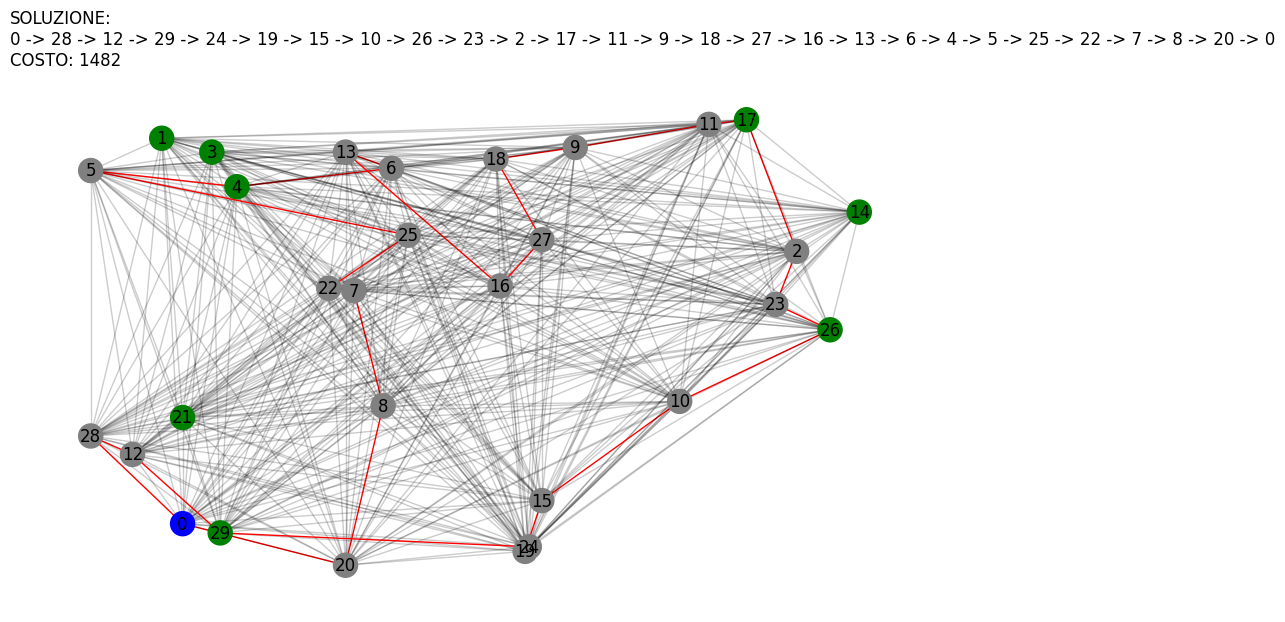

In [84]:
import itertools
import networkx as nx 
import utility_function as uf

#Caricamento del grafo da file
#scelta istanza
graph_file = "istances/USA.gml"
batteria_max = 250

#lettura grafo
G = nx.read_gml(graph_file, destringizer=int)

#applicazione algoritmo greedy
soluzione, batteria_per_nodo = greedy_cheapest_insertion(G,batteria_max)
soluzione, batteria_per_nodo = uf.add_colonnine_to_tour(G, soluzione, batteria_per_nodo, batteria_max)

costo= uf.costo(G,soluzione, batteria_per_nodo)
print("COSTO VECCCHIO: ", costo)


#soluzione, batteria_per_nodo = tabu_3opt(G, soluzione, batteria_per_nodo,4,4)
soluzione, batteria_per_nodo = tabu_2opt_penalizzazione(G, soluzione, batteria_per_nodo,4,4)
costo= uf.costo(G,soluzione, batteria_per_nodo)

soluzione = uf.compact_list(soluzione)

print("COSTO NUOVO: ", costo)

print(batteria_per_nodo)
print(soluzione)

uf.draw_solution(G, soluzione, costo)

In [ ]:
import itertools
import networkx as nx 
import utility_function as uf

#Caricamento del grafo da file
#scelta istanza
graph_file = "istances/graph.gml"
batteria_max = 150

#lettura grafo
G = nx.read_gml(graph_file, destringizer=int)

#applicazione algoritmo greedy
soluzione, batteria_per_nodo = greedy_random_insertion(G,batteria_max)

#aggiungiamo le colonnine necessarie per renderla ammissibile
soluzione, batteria_per_nodo = uf.add_colonnine_to_tour(G, soluzione, batteria_per_nodo, batteria_max)

costo= uf.costo(G,soluzione, batteria_per_nodo)
print("COSTO VECCCHIO: ", costo)


soluzione, batteria_per_nodo = tabu_3opt(G, soluzione, batteria_per_nodo,2,20)
#soluzione, batteria_per_nodo = local_3opt(G, soluzione, batteria_per_nodo)
costo= uf.costo(G,soluzione, batteria_per_nodo)

print("COSTO NUOVO: ", costo)

print(batteria_per_nodo)
print(soluzione)

uf.draw_solution(G, soluzione, costo)

### ILS - con mossa che cambia l'insieme di colonnine visitate

In [99]:
import networkx as nx
import utility_function as uf
import numpy as np
import random

def mossa_rimescolo_colonnine(G : nx.Graph, soluzione : list, colonnine_totali):
    '''
    Mossa distruttiva che effettua cambi che no avvengono normalmente durante la ricerca locale.
    Agisce sulle colonnine, cambiandole tra quelle dentro e fuori la soluzione.
    Non è chiaro ma fa lo stesso :-D
    '''
   
    #recupero tutte le colonnine del grado G
    soluzione = uf.compact_list(soluzione)
  
    colonnine_in_soluzione = [node for node in soluzione if G.nodes[node]['type'] == "colonnina"]

    for i in range(1,len(colonnine_in_soluzione)-1):
        
        if G.nodes[soluzione[i]]['type'] == "colonnina":
            #se è una colonnina la cambio
            random_colonnina = random.choice(colonnine_totali)
            soluzione[i] = random_colonnina
    
    return soluzione
             
def mossa_rimescolo_colonnine2(G : nx.Graph, soluzione : list):
    '''
    Mossa distruttiva che effettua cambi che no avvengono normalmente durante la ricerca locale.
    Agisce sulle colonnine, cambiandole tra quelle dentro e fuori la soluzione.
    Non è chiaro ma fa lo stesso :-D
    '''
   
    #recupero tutte le colonnine del grado G
    #colonnine_totali = [node for node in G.nodes if G.nodes[node]['type'] == "colonnina"]
    colonnine_in_soluzione = [node for node in soluzione if G.nodes[node]['type'] == "colonnina"]

    random_colonnina = random.choice(colonnine_in_soluzione)
    soluzione.remove(random_colonnina)
    
    return soluzione


def ils(G,soluzione,batteria_per_nodo,iterazioni):
    soluzione_best = soluzione.copy()
    batteria_per_nodo_best = batteria_per_nodo.copy()
    
    costo_best = uf.costo(G,soluzione,batteria_per_nodo)

    batteria_max = batteria_per_nodo[0]

    nuova_soluzione = soluzione.copy()

    iterazioni_no_improvement = 0

    colonnine_totali = [node for node in G.nodes if G.nodes[node]['type'] == "colonnina"]

    

    while iterazioni_no_improvement < iterazioni:

        print("iterazione", iterazioni_no_improvement)

       
        batteria_per_nodo_nuova = uf.calcolo_batteria_per_nodo(G,nuova_soluzione,batteria_max)

        #local search
        nuova_soluzione_local, batteria_per_nodo_nuova_local = local_2opt_swap(G,nuova_soluzione,batteria_per_nodo_nuova)

        if uf.check_batteria_negativa(batteria_per_nodo_nuova_local) == True:
            #print("batteria negativa - WARNING")
            nuova_soluzione_local, batteria_per_nodo_nuova_local = uf.add_colonnine_to_tour_reverse(G,nuova_soluzione,batteria_per_nodo_nuova,batteria_max)
        

        costo = uf.costo(G,nuova_soluzione_local,batteria_per_nodo_nuova_local)
        if costo < costo_best:
            
            costo_best = costo
            soluzione_best = nuova_soluzione_local.copy()
            batteria_per_nodo_best = batteria_per_nodo_nuova_local.copy()

            iterazioni_no_improvement = 0

            print("Costo ILS: ", costo_best)
              
        else:
            iterazioni_no_improvement += 1
        
        nuova_soluzione = nuova_soluzione_local

        nuova_soluzione = mossa_rimescolo_colonnine(G,nuova_soluzione,colonnine_totali)
        batteria_per_nodo_nuova = uf.calcolo_batteria_per_nodo(G,nuova_soluzione,batteria_max)

    costo_finale = uf.costo(G, soluzione_best, batteria_per_nodo_best)
  


    return soluzione_best, batteria_per_nodo_best



### Ant Colony


{'0': (24, 28), '2': (142, 175), '5': (177, 6), '6': (178, 78), '7': (125, 69), '8': (75, 76), '9': (187, 122), '10': (77, 147), '11': (197, 154), '12': (54, 16), '13': (185, 67), '15': (34, 114), '16': (127, 104), '18': (182, 103), '19': (12, 110), '20': (6, 67), '22': (126, 63), '23': (119, 170), '24': (14, 111), '25': (149, 82), '27': (147, 114), '28': (62, 6)}
lista clienti: [('0', (24, 28)), ('10', (77, 147)), ('11', (197, 154)), ('12', (54, 16)), ('13', (185, 67)), ('15', (34, 114)), ('16', (127, 104)), ('18', (182, 103)), ('19', (12, 110)), ('2', (142, 175)), ('20', (6, 67)), ('22', (126, 63)), ('23', (119, 170)), ('24', (14, 111)), ('25', (149, 82)), ('27', (147, 114)), ('28', (62, 6)), ('5', (177, 6)), ('6', (178, 78)), ('7', (125, 69)), ('8', (75, 76)), ('9', (187, 122))]
{'path_cost': 1265, 'ants_used': 1, 'epoch': 1224, 'round_trips': 1, 'clock': 0}
{'path_cost': 1101, 'ants_used': 129, 'epoch': 2428, 'round_trips': 2, 'clock': 0}
{'path_cost': 1081, 'ants_used': 701, 'epoc

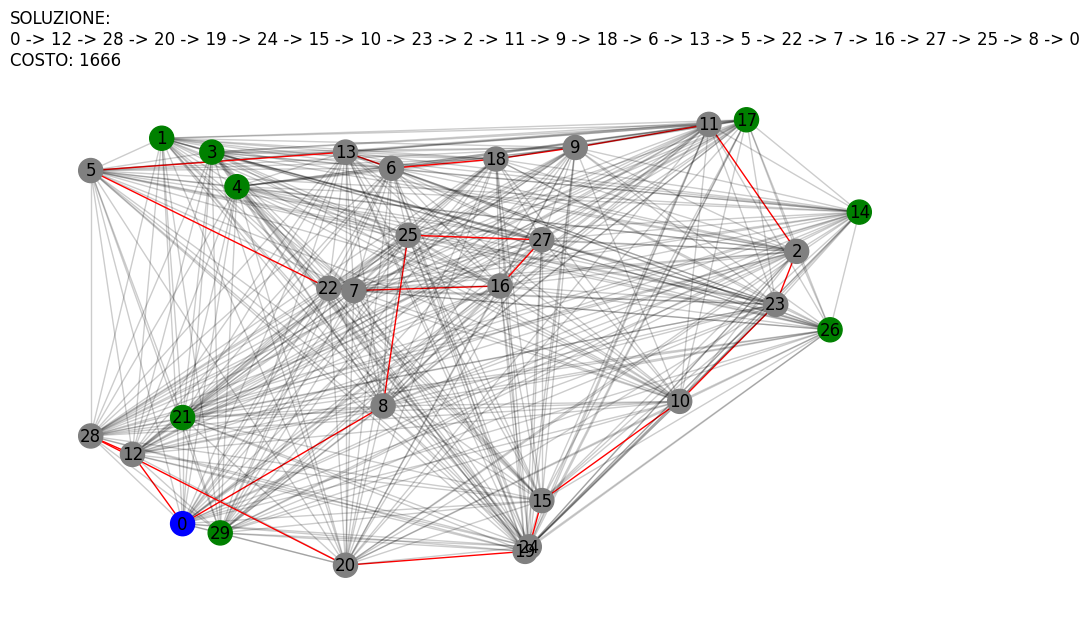

In [4]:
import ant_colony
import networkx as nx
import utility_function as uf

graph_file = "istances/USA.gml"
batteria_max = 250

G = nx.read_gml(graph_file, destringizer=int)
#estraggo i clienti
clienti = [node for node in G.nodes if G.nodes[node]['type'] == "cliente" or G.nodes[node]['type'] == "deposito"]

client_dict = {str(i): tuple(G.nodes[i]['pos']) for i in clienti}
for i in clienti:
    tupla = [ int(G.nodes[i]['pos'][1]), int(G.nodes[i]['pos'][0]) ]
    tupla = tuple(tupla)
    client_dict[str(i)] = tupla

print(client_dict)

clienti = list(sorted(client_dict.items()))
print("lista clienti:", clienti)

results = ant_colony.AntColonyRunner(clienti, distance_power=1, verbose=True, plot=False)
#[('0', (97, 50)), ('4', (93, 54)), ('10', (95, 91)), ('13', (68, 123)), ('14', (72, 156)), ('8', (122, 180)), ('1', (79, 185)), ('11', (45, 162)), ('5', (24, 145)), ('7', (3, 139)), ('6', (58, 8)), ('6', (58, 8)), ('0', (97, 50))]
print("results:",results)

#estraggo la soluzione
soluzione = []
for i in results:
    soluzione.append(int(i[0]))

soluzione= uf.compact_list(soluzione)

batteria_per_nodo = uf.calcolo_batteria_per_nodo(G, soluzione, batteria_max)

soluzione1, batteria_per_nodo1 = uf.add_colonnine_to_tour(G, soluzione,batteria_per_nodo, batteria_max)
soluzione2, batteria_per_nodo2 = uf.add_colonnine_to_tour_reverse(G, soluzione,batteria_per_nodo, batteria_max)
soluzione3, batteria_per_nodo3 = uf.add_colonnine_to_tour_rapporto(G, soluzione,batteria_per_nodo, batteria_max)

costo = uf.costo(G, soluzione1, batteria_per_nodo1)
costo2 = uf.costo(G, soluzione2, batteria_per_nodo2)
costo3 = uf.costo(G, soluzione3, batteria_per_nodo3)

print(costo, costo2, costo3)


print(soluzione)
print(batteria_per_nodo)
uf.draw_solution(G, soluzione, costo)

In [ ]:
soluzione = []
for i in results:
    soluzione.append(int(i[0]))
print(soluzione)

[0, 4, 10, 13, 8, 1, 14, 11, 5, 7, 6, 6, 0]


### Simulated Annealing

In [ ]:
import networkx as nx
import utility_function as uf
import random as rnd
import numpy as np

#simulated annealing per TSP

    

def simulated_annealing(G, soluzione:list, batteria_per_nodo:list, temp_max:int, alpha:int, batteria_max:int):
    temp = temp_max
    temp_min = 0.1
    soluzione_attuale = soluzione.copy()
    soluzione_best = soluzione.copy()
    costo_best = uf.costo(G, soluzione, batteria_per_nodo)
    fitness_list = []

    #creo nuova soluzione partendo da questa con city insertion
    while temp > temp_min:
        i= rnd.randint(1,len(soluzione)-2)
        j= rnd.randint(1,len(soluzione)-2)

        soluzione_temp=soluzione_attuale.copy()
        soluzione_temp[i], soluzione_temp[j] = soluzione_temp[j], soluzione_temp[i]

        batteria_per_nodo_temp = uf.calcolo_batteria_per_nodo(G, soluzione_temp, batteria_max)
        if uf.check_batteria_negativa(batteria_per_nodo_temp) == False: #ammissibile
            costo = uf.costo(G,soluzione_temp,batteria_per_nodo_temp)
            if costo < costo_best: #meglio
                print("costo best: ", costo_best)
                soluzione_best = soluzione_temp
                costo_best = costo
                soluzione_attuale = soluzione_temp
                fitness_list.append(costo_best)
            else:
                delta = costo - costo_best
                if rnd.random() < np.exp(-delta/temp):
                    soluzione_attuale = soluzione_temp  
                    fitness_list.append(costo)
                else:
                    fitness_list.append(costo)
          

          
                


        temp = temp*alpha
    batteria_per_nodo_best = uf.calcolo_batteria_per_nodo(G, soluzione_best, batteria_max)
    return soluzione_best, batteria_per_nodo_best, fitness_list


COSTO VECCCHIO:  1936
iterazione 0
Costo ILS:  1377
iterazione 0
Costo ILS:  1343
iterazione 0
iterazione 1
iterazione 2
iterazione 3
iterazione 4
iterazione 5
iterazione 6
iterazione 7
iterazione 8
iterazione 9
iterazione 10
iterazione 11
iterazione 12
iterazione 13
iterazione 14
COSTO NUOVO:  1343
[250, 250, 210.03751759462384, 197.23126911975814, 250, 201.7402859519454, 149.10949648418233, 143.0267339538841, 107.9696376679679, 85.60895789297001, 53.546518809207214, 250, 214.3068634048505, 250, 212.1450135385046, 199.1066087280993, 162.98182499172242, 143.33494228733392, 250, 240.7804555427071, 181.907711424567, 250, 232.9706136340736, 185.08533405882207, 130.88201312735146, 108.52133335235357, 106.28526537485378, 61.56390582485798, 18.610442635028924]
[0, 29, 12, 28, 21, 8, 22, 7, 16, 27, 25, 4, 5, 4, 6, 13, 18, 9, 17, 11, 2, 26, 23, 10, 15, 19, 24, 20, 0]


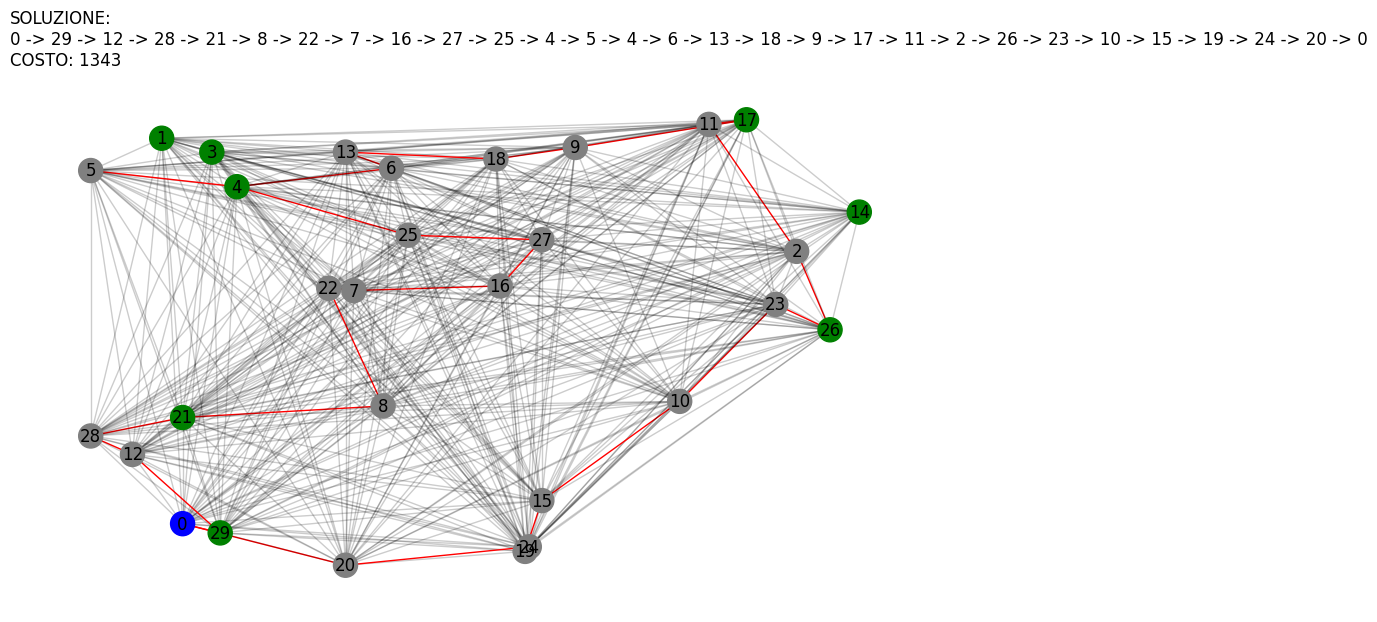

In [103]:
import itertools
import networkx as nx 
import utility_function as uf
import matplotlib.pyplot as plt

#Caricamento del grafo da file
#scelta istanza
graph_file = "istances/USA.gml"
batteria_max = 250

#lettura grafo
G = nx.read_gml(graph_file, destringizer=int)

#applicazione algoritmo greedy
soluzione, batteria_per_nodo = greedy_cheapest_insertion(G,batteria_max)

#aggiungiamo le colonnine necessarie per renderla ammissibile
soluzione, batteria_per_nodo = uf.add_colonnine_to_tour(G, soluzione, batteria_per_nodo, batteria_max)

costo= uf.costo(G,soluzione, batteria_per_nodo)
print("COSTO VECCCHIO: ", costo)


soluzione, batteria_per_nodo = ils(G, soluzione, batteria_per_nodo, 15)
#soluzione, batteria_per_nodo = local_2opt_swap(G, soluzione, batteria_per_nodo)
costo= uf.costo(G,soluzione, batteria_per_nodo)

print("COSTO NUOVO: ", costo)

print(batteria_per_nodo)
print(soluzione)

uf.draw_solution(G, soluzione, costo)


## Algoritmi Genetici

### Swap crossover

In [ ]:
import utility_function as uf
import random as rnd

def random_swap(sol):
    i= rnd.randint(1,len(sol)-2)
    j= rnd.randint(1,len(sol)-2)

    soluzione_temp=sol.copy()
    soluzione_temp[i], soluzione_temp[j] = soluzione_temp[j], soluzione_temp[i]

    return soluzione_temp

def generate_population_swap(G,parents_list, n_figli, batteria_max):
    children_list = []
    for i in parents_list:
        for j in range(n_figli):
            figlio = random_swap(i[0])
            batteria_per_nodo = uf.calcolo_batteria_per_nodo(G, figlio, batteria_max)

            if uf.check_batteria_negativa(batteria_per_nodo) == False:
                costo = uf.costo(G, figlio, batteria_per_nodo)
                children_list.append( (figlio, costo))
               

    #aggiungo i parents alla lista
    for i in parents_list:
        batteria_per_nodo = uf.calcolo_batteria_per_nodo(G, i[0], batteria_max)
        if uf.check_batteria_negativa(batteria_per_nodo) == False:
            costo = uf.costo(G, i[0], batteria_per_nodo)    
            children_list.append( (i[0], costo))

    #elimino i figli non ammissibili


    #ordino la lista dei figli in base al costo
    children_list.sort(key=lambda x: x[1])
    
    return children_list

def ga_swap_crossover(G, sol_list : list, n_figli : int, n_figli_per_epoca : int, max_generation : int, batteria_max : int):
    for i in range(max_generation):
        #genero i figli
        children_list = generate_population_swap(G, sol_list, n_figli, batteria_max)

        #seleziono i migliori figli
        sol_list = children_list[:n_figli_per_epoca]

        #stampo il miglior figlio
        print("Best child: ", sol_list[0][1])
    
    soluzione_best = sol_list[0][0]
    batteria_per_nodo_best = uf.calcolo_batteria_per_nodo(G,soluzione_best,batteria_max)
    costo_best = sol_list[0][1]

    print("costo FINALE:", costo_best)


    return soluzione_best, batteria_per_nodo_best
    
    


### GA per TSP

Si fa ereditare al figlio, dal secondo genitore, solo la posizione relativa dei nodi e non quella assoluta. Dal primo genitore invece quella assoluta.



In [39]:

import utility_function as uf
import random as rnd

def crossover(padre: list, madre: list, idx_taglio : int):
    '''
    Genera una una soluzione crossover a partire da padre e madre. Dal padre eredita i primi idx_taglio elementi, dalla madre gli altri (in modo relativo)
    '''
    figlio = padre[:idx_taglio]
    for i in madre:
        if i not in figlio:
            figlio.append(i)
    figlio.append(0)

    '''print("madre:", madre)
    print("padre:", padre)
    print("figlio:", figlio)'''
    
    return figlio

def generate_population_crossover(G,parents_list, batteria_max):
    children_list = []
    for i in itertools.permutations(parents_list,2):
        
        taglio = rnd.randint(2,len(i[0][0])-2)
      
       
        figlio = crossover(i[0][0],i[1][0], taglio)
        batteria_per_nodo = uf.calcolo_batteria_per_nodo(G, figlio, batteria_max)

        if uf.check_batteria_negativa(batteria_per_nodo) == False:
            costo = uf.costo(G, figlio, batteria_per_nodo)
            #print("Trovata ammissibile con costo:", costo, figlio)
            
        else:
            figlio, batteria_per_nodo = uf.add_colonnine_to_tour(G, figlio, batteria_per_nodo, batteria_max)
            costo = uf.costo(G, figlio, batteria_per_nodo)
           # print("figlio non ammissibile")

        children_list.append( (figlio, costo))
        print(children_list)

    #aggiungo i parents alla lista
    for i in parents_list:
        batteria_per_nodo = uf.calcolo_batteria_per_nodo(G, i[0], batteria_max)
        if uf.check_batteria_negativa(batteria_per_nodo) == False:
            costo = uf.costo(G, i[0], batteria_per_nodo)    
            children_list.append( (i[0], costo))

    
        #ordino la lista dei figli in base al costo
        children_list.sort(key=lambda x: x[1])
        
    return children_list

def ga_crossover(G, sol_list, max_popolazione, max_generation, batteria_max):
    for i in range(max_generation):
        print("Generazione: ", i)
        #genero i figli
        children_list = generate_population_crossover(G, sol_list, batteria_max)

        #seleziono i migliori figli
        sol_list = children_list[:max_popolazione]

        #stampo il miglior figlio
        print("Best child: ", sol_list[0][1])
    
    soluzione_best = sol_list[0][0]
    batteria_per_nodo_best = uf.calcolo_batteria_per_nodo(G,soluzione_best,batteria_max)
    costo_best = sol_list[0][1]

    print("costo FINALE:", costo_best)


    return soluzione_best, batteria_per_nodo_best


1825 1543
Generazione:  0
[([0, 6, 10, 3, 13, 1, 3, 4, 3, 8, 3, 5, 3, 14, 3, 7, 11, 3, 0], 1634)]
[([0, 6, 10, 3, 13, 1, 3, 4, 3, 8, 3, 5, 3, 14, 3, 7, 11, 3, 0], 1634), ([0, 3, 13, 6, 3, 1, 3, 10, 3, 4, 3, 8, 3, 5, 3, 14, 3, 7, 11, 9, 2, 12, 0], 2195)]
Best child:  1543
Generazione:  1
[([0, 6, 10, 3, 13, 1, 3, 4, 3, 8, 3, 5, 3, 14, 3, 7, 11, 3, 0], 1634)]
[([0, 6, 10, 3, 13, 1, 3, 4, 3, 8, 3, 5, 3, 14, 3, 7, 11, 3, 0], 1634), ([0, 6, 10, 3, 14, 13, 1, 9, 8, 11, 2, 4, 12, 5, 12, 7, 12, 0], 1718)]
[([0, 6, 10, 3, 13, 1, 3, 4, 3, 8, 3, 5, 3, 14, 3, 7, 11, 3, 0], 1634), ([0, 6, 10, 3, 14, 13, 1, 9, 8, 11, 2, 4, 12, 5, 12, 7, 12, 0], 1718), ([0, 6, 10, 3, 14, 13, 1, 3, 4, 3, 8, 3, 5, 12, 7, 11, 9, 2, 12, 0], 1982)]
[([0, 6, 10, 3, 13, 1, 3, 4, 3, 8, 3, 5, 3, 14, 3, 7, 11, 3, 0], 1634), ([0, 6, 10, 3, 14, 13, 1, 9, 8, 11, 2, 4, 12, 5, 12, 7, 12, 0], 1718), ([0, 6, 10, 3, 14, 13, 1, 3, 4, 3, 8, 3, 5, 12, 7, 11, 9, 2, 12, 0], 1982), ([0, 6, 10, 3, 13, 1, 3, 4, 3, 8, 3, 5, 3, 14, 3, 7, 11, 9,

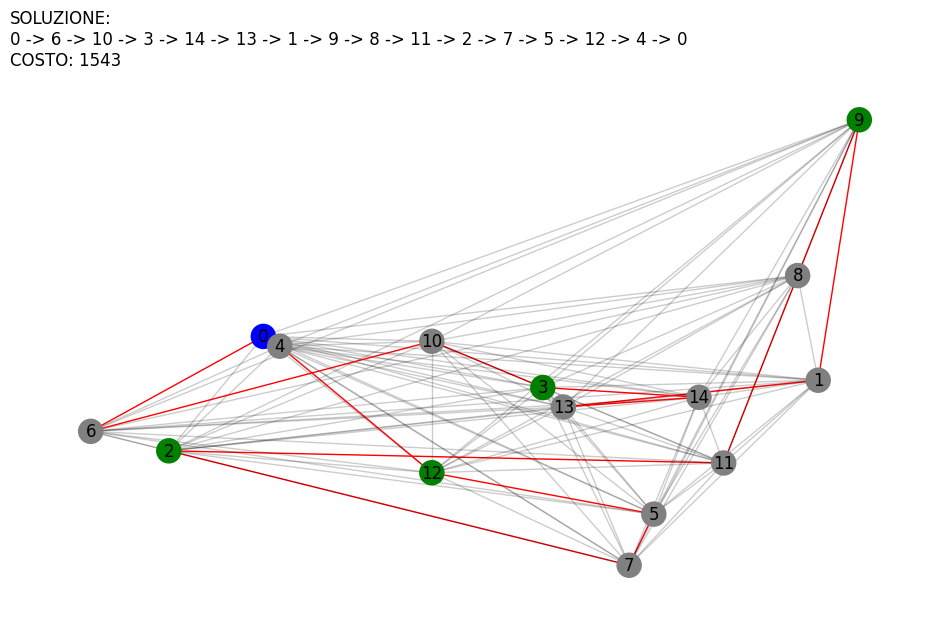

In [40]:
import itertools
import networkx as nx 
import utility_function as uf

#Caricamento del grafo da file
#scelta istanza
graph_file = "istances/graph.gml"
batteria_max = 150

#lettura grafo
G = nx.read_gml(graph_file, destringizer=int)

#applicazione algoritmo greedy
soluzione1, batteria_per_nodo = greedy_farthest_insertion(G,batteria_max)
soluzione1, batteria_per_nodo= uf.add_colonnine_to_tour(G, soluzione1, batteria_per_nodo, batteria_max)
costo1 = uf.costo(G,soluzione1,batteria_per_nodo)

soluzione2,  batteria_per_nodo= greedy_cheapest_insertion(G,batteria_max)
soluzione2, batteria_per_nodo= uf.add_colonnine_to_tour(G, soluzione2, batteria_per_nodo, batteria_max)
costo2 = uf.costo(G,soluzione2,batteria_per_nodo)


soluzione4,  batteria_per_nodo= greedy_random_insertion_colonnine(G,batteria_max)
costo4 = uf.costo(G,soluzione4,batteria_per_nodo)


soluzione5, batteria_per_nodo = greedy_random_insertion(G,batteria_max)
soluzione5, batteria_per_nodo= uf.add_colonnine_to_tour(G, soluzione5, batteria_per_nodo, batteria_max)
costo5= uf.costo(G,soluzione5,batteria_per_nodo)



sol_list = [(soluzione4,costo4), (soluzione5,costo5)]

print(costo5,costo4)

soluzione, batteria_per_nodo = ga_crossover(G, sol_list, 5, 5,batteria_max)
#soluzione, batteria_per_nodo = local_3opt(G, soluzione, batteria_per_nodo)
costo= uf.costo(G,soluzione, batteria_per_nodo)

print("COSTO NUOVO: ", costo)

print(batteria_per_nodo)
print(soluzione)

uf.draw_solution(G, soluzione, costo)

[0, 1, 4, 5, 6, 7, 8, 10, 11, 13, 14]
[[8, 58], [50, 97], [54, 93], [91, 95], [123, 68], [139, 3], [145, 24], [156, 72], [162, 45], [180, 122], [185, 79]]
11
Graph:  {0: {1: 57.3149195236284, 2: 57.8013840664737, 3: 90.87353850269065, 4: 115.43396380615195, 5: 142.0774436706967, 6: 141.15594213493105, 7: 148.66068747318505, 8: 154.5477272560163, 9: 183.52111595127138, 10: 178.24140933015536}, 1: {0: 57.3149195236284, 2: 5.656854249492381, 3: 41.048751503547585, 4: 78.54934754662193, 5: 129.4488315899375, 6: 119.80818002123227, 7: 108.90821823902914, 8: 123.48279232346505, 9: 132.38202294873727, 10: 136.194713553794}, 2: {0: 57.8013840664737, 1: 5.656854249492381, 3: 37.05401462729781, 4: 73.38937252763509, 5: 123.79418403139947, 6: 114.20157617125956, 7: 104.1393297462587, 8: 118.18629362155326, 9: 129.29423807734048, 10: 131.7459676802292}, 3: {0: 90.87353850269065, 1: 41.048751503547585, 2: 37.05401462729781, 4: 41.86884283091664, 5: 103.76897416858277, 6: 89.20201791439474, 7: 68.94

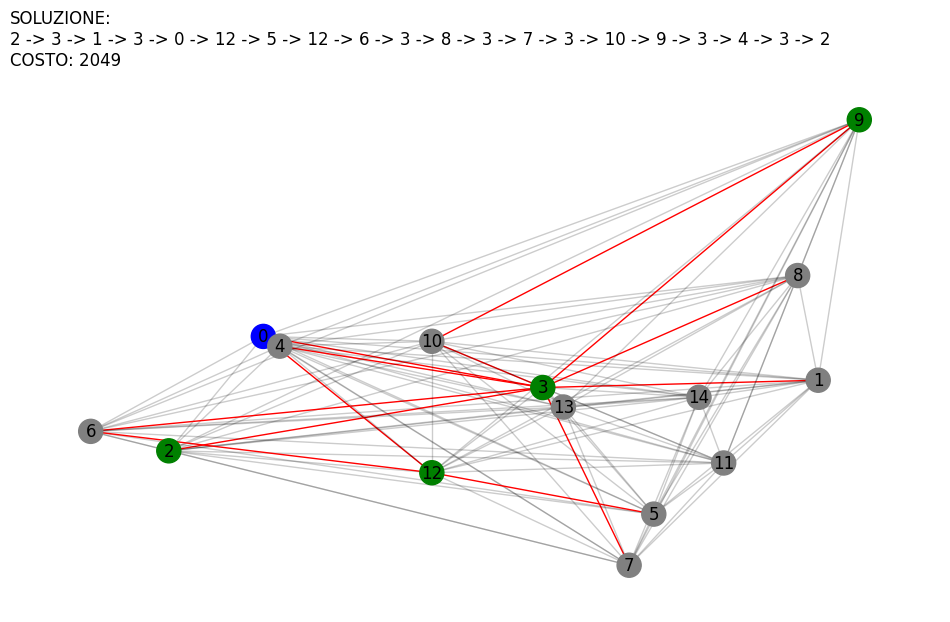

In [ ]:
import ant_colony
import networkx as nx
import utility_function as uf

graph_file = "istances/graph.gml"
batteria_max = 150

G = nx.read_gml(graph_file, destringizer=int)
#estraggo i clienti
clienti = [node for node in G.nodes if G.nodes[node]['type'] == "cliente" or G.nodes[node]['type'] == "deposito"]
print(clienti)

#crea dizionario dei clienti 
client_dict = [G.nodes[i]['pos'] for i in clienti]
for i in clienti:
    tupla = [ int(G.nodes[i]['pos'][1]), int(G.nodes[i]['pos'][0]) ]
    tupla = tuple(tupla)
   

clienti = list(sorted(client_dict))
print(clienti)
print(len(clienti))

results = tsp(clienti)

print("RES", results)

#estraggo la soluzione
soluzione = results[1]

batteria_per_nodo = uf.calcolo_batteria_per_nodo(G, soluzione, batteria_max)
soluzione, batteria_per_nodo = uf.add_colonnine_to_tour(G, soluzione,batteria_per_nodo, batteria_max)

costo = uf.costo(G, soluzione, batteria_per_nodo)
print(soluzione)
print(batteria_per_nodo)
uf.draw_solution(G, soluzione, costo)
